Date: 2024-12-11

Latest change when and what:

Notes:

# Baseline models: Bag og Words and tf-idf

Trying different baseline models and comparing their outcomes. Please note - all the models were first run using the training and the validation datasets. When the parameters of the models had been chosen, we then finally tested on the test dataset, too. So, the test dataset was only used once.

In [8]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve, average_precision_score, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

import pickle as pkl
from sklearn.datasets import make_classification
from wordcloud import WordCloud

In [9]:
# loading train, test and validation datasets - lowercase!
train_data = pd.read_csv("../2_preprocessing/train_lowercase.csv")
test_data = pd.read_csv("../2_preprocessing/test_lowercase.csv")
val_data = pd.read_csv('../2_preprocessing/validation_lowercase.csv')

In [161]:
# checking average number of characters in scripts - just to get info
average_characters = train_data['script'].apply(len).mean()
average_characters = round(average_characters,0)

print(f"Average number of characters: {average_characters}")

Average number of characters: 124366.0


# Create custom stopwords

I prompted chatgpt to create a list of stop words which includes the most common stopwords (prepositions, articles, etc.) but not gendered words and without special characters

In [32]:
stop_words_list = ['a', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'along', 'am', 'among', 'an', 'and', 'any', 
'are', 'arent', 'around', 'as', 'at', 'be', 'because', 'been', 'before', 'behind', 'being', 'below', 'beneath', 
'beside', 'besides', 'between', 'beyond', 'both', 'but', 'by', 'cant', 'cannot', 'concerning', 'considering', 
'could', 'couldnt', 'despite', 'did', 'didnt', 'do', 'does', 'doesnt', 'doing', 'dont', 'down', 'during', 'each', 
'except', 'few', 'following', 'for', 'from', 'further', 'had', 'hadnt', 'has', 'hasnt', 'have', 'havent', 'having', 
'here', 'heres', 'how', 'hows', 'i', 'id', 'ill', 'im', 'ive', 'if', 'in', 'inside', 'into', 'is', 'isnt', 'it', 
'its', 'itself', 'lets', 'like', 'me', 'more', 'most', 'mustnt', 'my', 'myself', 'near', 'no', 'nor', 'not', 'of', 
'off', 'on', 'once', 'only', 'onto', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 
'own', 'past', 'regarding', 'same', 'shant', 'should', 'shouldnt', 'since', 'so', 'some', 'such', 'than', 'that', 
'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'theres', 'these', 'they', 'theyd', 
'theyll', 'theyre', 'theyve', 'this', 'those', 'through', 'throughout', 'to', 'too', 'toward', 'under', 'underneath',
 'until', 'up', 'upon', 'very', 'was', 'wasnt', 'we', 'wed', 'well', 'weve', 'were', 'werent', 'what', 'whats',
  'when', 'whens', 'where', 'wheres', 'which', 'while', 'who', 'whos', 'whom', 'why', 'whys', 'with', 'within', 'without', 
  'wont', 'would', 'wouldnt', 'you', 'youd', 'youll', 'youre', 'youve', 'your', 'yours', 'yourself', 'yourselves', 'aren', 
  'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn',
   've', 'wasn', 'weren', 'won', 'wouldn']

# Find duplicates
duplicates = [word for word, count in Counter(stop_words_list).items() if count > 1]
print("Duplicates:", duplicates)

len(stop_words_list)
if "im" in stop_words_list:
    print('word in list')

Duplicates: []
word in list


In [ ]:
# # List of gendered words to remove
# gendered_words = ["he", "she", "him", "his", "her", "hers", "himself", "herself", "he'll", "she'll"]

# # Remove gendered words
# stop_words_list = [word for word in stop_words_list if word not in gendered_words]

## Bag of Words (BoW)

.fit_transform uses the input to create the frequency matrix of words.
.transform counts the words in the input using the frequency matrix already created with the training data
so if a word is not present in the frequency matrix created with the training data, it is lost

In [33]:
# creating frequency matrix using the training data and transforming the validation and the test dataset
# train data 
texts_train = train_data["script"].to_list()
y_train = train_data.passed_bechdel.to_list()

# create frequency matrix of words
vectorizer = CountVectorizer(stop_words = stop_words_list)
features_train = vectorizer.fit_transform(texts_train) # only for training!

# validation data 
texts_val = val_data["script"].to_list()
y_val = val_data.passed_bechdel.to_list()

# plot the words in the validation dataset in the matrix made on the training data 
features_val = vectorizer.transform(texts_val) # notice - only transform, not fitting

# test data 
texts_test = test_data["script"].to_list()
y_test = test_data.passed_bechdel.to_list()

# plot the words in the test dataset in the matrix made on the training data 
features_test = vectorizer.transform(texts_test) 

In [34]:
# sanity check
print(features_train.shape)
print(len(vectorizer.vocabulary_))
#vectorizer.vocabulary_

(1418, 338922)
338922


In [ ]:
# 339,126 was the number of tokens before removing stopwords
print('percentage of words removed;', round((((339126-338922) / 339126)*100),2), "%") # did not remove a lot of words

percentage of words removed; 0.06 %


### BoW logistic regression
The logistic regression parameter grid search was run using the liblinear and the saga solver and different penalty terms were tested. Different numbers of max iterations and C (inverse regularization parameter) were tested, too. 

In [ ]:
# Example parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.005, 0.01],  # Regularization strength (inverse, smaller value = more regularization)
    'penalty': ['l1', 'l2'],               # Type of regularization
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000, 10000]       
}

# Define the logistic regression model
log_reg = LogisticRegression()#random_state=42, max_iter = 500)

# Set up GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train, y_train)

# Output the best hyperparameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# You can also access the best estimator (model) directly
best_model = grid_search.best_estimator_

# evaluate on validation dataset
val_score = best_model.score(features_val, y_val)
print("Validation dataset accuracy with best model:", val_score)

According to the parameter grid search above, the best combination of parameters are as follows.
Best parameters: {'C': 0.005, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'} (I have deleted the output, because it looks crazy in github)

However - the model is having issues with converging. Through trial and error, I ended up implementing the elasticnet penalty term instead (which takes both L1 and L2 into account) and increasing the number of max iterations to 10,000.

In [ ]:
#initializing logistic regression model
clf_log_reg = LogisticRegression(
    penalty = 'elasticnet', # used elasticnet to use both the L1 and L2 penalty terms
    C = 0.001, # added more regularization 
    #random_state=42 - doesn't make a difference
    solver = 'saga',
    max_iter = 10000, #upped the number of iterations from 500 to 1000 to make the model converge
    l1_ratio = 0.5).fit(features_train, y_train) # the ratio of the penalty terms is 50/50

In [ ]:
# save / reload model
#pkl.dump(clf_log_reg, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/BoW_log_reg_elasticnet_saga.pkl', 'wb')) # save the model
clf_log_reg = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/BoW_log_reg_elasticnet_saga.pkl','rb'))

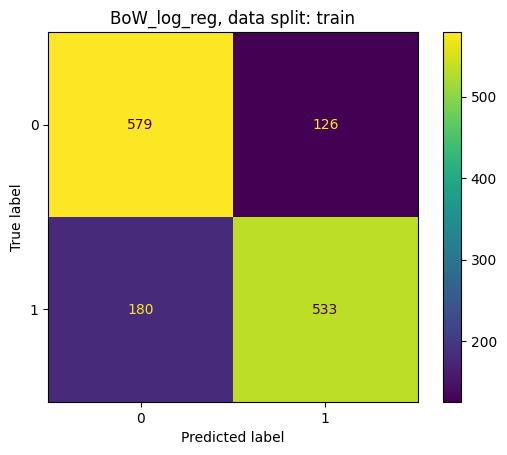

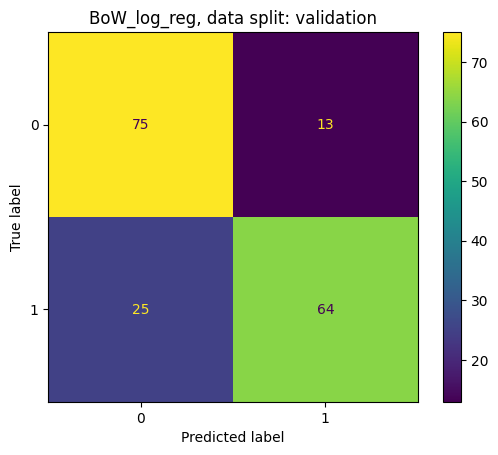

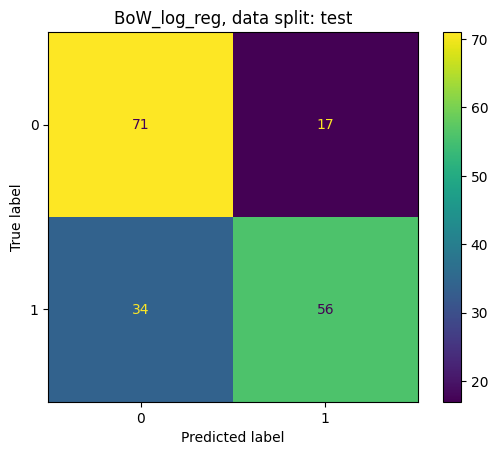

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.7842,0.7770,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.7853,0.7711,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.7135,0.6871,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182


In [ ]:
# evaluate model on validation dataset and save performance metrics
performance_df = pd.DataFrame()
model = clf_log_reg
model_name = 'BoW_log_reg'

for x, y, nsplit in zip([features_train, features_val, features_test],
                        [y_train, y_val, y_test],
                        ['train', 'validation', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)
    roc_auc = roc_auc_score(np.array(y), model.predict_proba(x)[:,1]) # takes the probabiltiy of label = 1 (=passing the bechdel-test)
  
    # create and plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y, preds)#, labels = [1,0])
    disp.ax_.set_title(f"{model_name}, data split: {nsplit}")
    plt.savefig(f'./output/figures/{model_name}_{nsplit}_confusion_matrix.jpeg')
    plt.show()

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'accuracy': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'roc_auc': roc_auc,
        # add confusion matrix values
        'true_negatives': disp.confusion_matrix[0][0],
        'true_positives': disp.confusion_matrix[1][1],
        'false_positives': disp.confusion_matrix[0][1],
        'false_negatives': disp.confusion_matrix[1][0],
        'precision': disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[0][1]),
        'recall':  disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[1][0]),
        'true_negative_rate': disp.confusion_matrix[0][0]/(disp.confusion_matrix[0][0]+disp.confusion_matrix[0][1]),
        'false_negative_rate': disp.confusion_matrix[1][0]/(disp.confusion_matrix[1][1]+disp.confusion_matrix[1][0]),
        'false_positive_rate': disp.confusion_matrix[0][1]/(disp.confusion_matrix[0][1]+disp.confusion_matrix[0][0])
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df


In [39]:
# double-checking for test
disp.confusion_matrix

array([[71, 17],
       [34, 56]])

### Check-out words which are not in the BoW model (not in training data)
In order to investigate which words are present in the validation and the test data but not in the training data, all datasets need to be vectorized independently using fit_transform(). Then, the percentage of "lost" tokens (i.e., tokens which are present in the validation or test data, but not present in the training data, and therefere will be lost when modeling) can be calculated.

In [42]:
# create frequency matrix of words for train 
vectorizer = CountVectorizer(stop_words = stop_words_list)
features_train = vectorizer.fit_transform(texts_train) 
vocab_train = set(vectorizer.vocabulary_.keys())
print("Tokens in training:", len(vocab_train))

# CREATE FOR VAL
vectorizer = CountVectorizer(stop_words = stop_words_list)
features_train = vectorizer.fit_transform(texts_val) 
vocab_val = set(vectorizer.vocabulary_.keys())
print("Tokens in validaiton:", len(vocab_val))

# CREATE FOR TEST
vectorizer = CountVectorizer(stop_words = stop_words_list)
features_train = vectorizer.fit_transform(texts_test) 
vocab_test = set(vectorizer.vocabulary_.keys())
print("Tokens in test:", len(vocab_test))

Tokens in training: 338922
Tokens in validaiton: 85269
Tokens in test: 89128


In [43]:
# percentage of tokens in validation not in training
print("percentage of tokens in validation data not present in training data: ")
print(round(len(vocab_val - vocab_train) / len(vocab_val),2))

percentage of tokens in validation data not present in training data: 
0.29


In [44]:
# percentage of tokens in test not in training
print("percentage of tokens in test data not present in training data: ")
print(round(len(vocab_test - vocab_train) / len(vocab_test),2))

percentage of tokens in test data not present in training data: 
0.31


In [46]:
# double-checking results
counter = 0
missing_words = []

# Check each word in vocab_val
for word in vocab_val:
    if word not in vocab_train:
        counter += 1
        missing_words.append(word)

# Output the results
#print(f"Words from vocab_val not in vocab_train: {missing_words}")
print(f"Number of words not in vocab_train: {counter}")
print("Percentage of tokens in valdation data not present in training data", round(counter/len(vocab_val),2))


Number of words not in vocab_train: 24686
Percentage of tokens in valdation data not present in training data 0.29


### BoW random forest

To select the hyperparameters of the model, I performed a randomized search, which randomly puts together x number of combinations of the different hyperparameter values (here 10 combinations), performs five-fold cross validation and finally estimates the best parameters given the scoring metric which I've given the model (here, f1). 

First, the frequency matrix of words is initialized again.

In [47]:
# creating frequency matrix using the training data and transforming the validation and the test dataset - again
# train data 
texts_train = train_data["script"].to_list()
y_train = train_data.passed_bechdel.to_list()

# create frequency matrix of words
vectorizer = CountVectorizer(stop_words = stop_words_list)
features_train = vectorizer.fit_transform(texts_train) # only for training!

# validation data 
texts_val = val_data["script"].to_list()
y_val = val_data.passed_bechdel.to_list()

# plot the words in the validation dataset in the matrix made on the training data 
features_val = vectorizer.transform(texts_val) # notice - only transform, not fitting

# test data 
texts_test = test_data["script"].to_list()
y_test = test_data.passed_bechdel.to_list()

# plot the words in the test dataset in the matrix made on the training data 
features_test = vectorizer.transform(texts_test) 

In [ ]:
## randomized search
param_grid = {
    'n_estimators': [10, 50, 100], # number of trees - deafult is 10
    'max_depth': [5, 10, 20],      # max number of splits/leaves (leaf = node without children) - stopping criteria # default is none
    'min_samples_split': [2, 5, 10], # min. number of samples required to split an internal node, default is 2
    'max_features': [0.3, 0.6, 0.9], # proportion of features to max. use in a tree (subset proportion) - default is 1.0 (= all features)
    'ccp_alpha': [0.01, 0.1, 1.0] # minimal-cost complexity pruning - to overvoid overfitting, default 0.0 
}

# Initialize the Random Forest Classifier
clf_forest = RandomForestClassifier(random_state=42)

clf_forest_rs = RandomizedSearchCV(estimator=clf_forest, 
                            param_distributions=param_grid,
                            scoring='f1',
                            n_iter=10, 
                            cv=5,
                            verbose = 2,
                            n_jobs = -1)


randomized_search = clf_forest_rs.fit(features_train, y_train) # removed output - looks strange in github

In [56]:
# get best parameters of the randomized search 
randomized_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'max_features': 0.9,
 'max_depth': 10,
 'ccp_alpha': 0.01}

In [57]:
clf_forest = randomized_search.best_estimator_ # model has already been fitted

In [ ]:
# # initializing random forest with the hyperparameters from the randomized search 
# clf_forest = RandomForestClassifier(
#     n_estimators = 100,
#     min_samples_split = 2, 
#     max_features = 0.3,
#     max_depth = 20, 
#     ccp_alpha = 0.01,
#     random_state=42).fit(features_train, y_train)

In [ ]:
# save / reload model
#pkl.dump(clf_forest, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/BoW_random_forest.pkl', 'wb')) # save the model
clf_forest = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/BoW_random_forest.pkl','rb'))

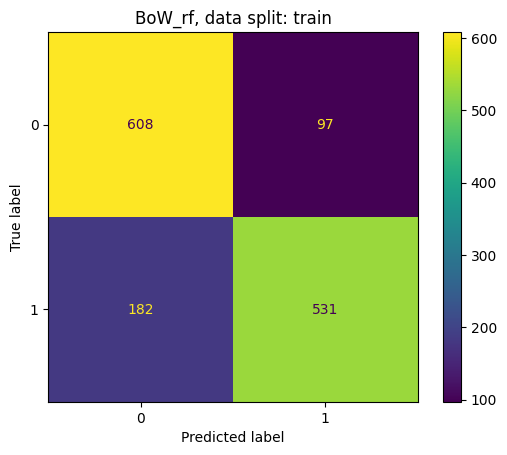

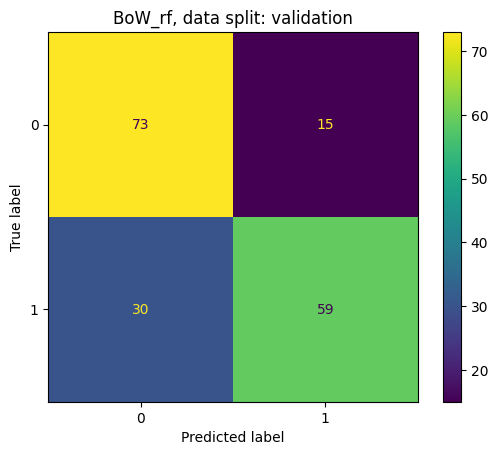

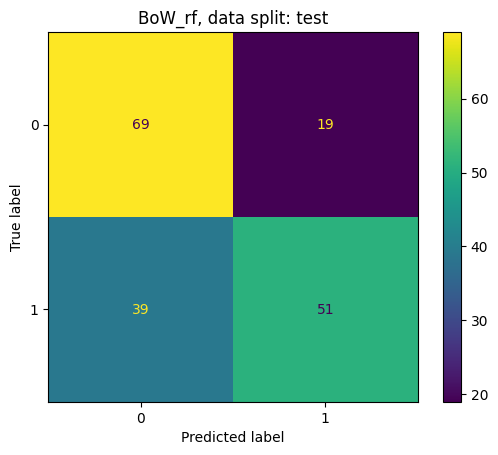

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.7842,0.7770,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.7853,0.7711,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.7135,0.6871,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182
3,BoW_rf,train,0.8032,0.7919,0.887491,608,531,97,182,0.845541,0.744741,0.862411,0.255259,0.137589
4,BoW_rf,validation,0.7458,0.7239,0.841420,73,59,15,30,0.797297,0.662921,0.829545,0.337079,0.170455
5,BoW_rf,test,0.6742,0.6375,0.736111,69,51,19,39,0.728571,0.566667,0.784091,0.433333,0.215909


In [59]:
model = clf_forest
model_name = 'BoW_rf'

for x, y, nsplit in zip([features_train, features_val, features_test],
                        [y_train, y_val, y_test],
                        ['train', 'validation', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)
    roc_auc = roc_auc_score(np.array(y), model.predict_proba(x)[:,1]) # takes the probabiltiy of label = 1 (=passing the bechdel-test)
  
    # create and plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y, preds)
    disp.ax_.set_title(f"{model_name}, data split: {nsplit}")
    plt.savefig(f'./output/figures/{model_name}_{nsplit}_confusion_matrix.jpeg')
    plt.show()

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'accuracy': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'roc_auc': roc_auc,
          # add confusion matrix values
        'true_negatives': disp.confusion_matrix[0][0],
        'true_positives': disp.confusion_matrix[1][1],
        'false_positives': disp.confusion_matrix[0][1],
        'false_negatives': disp.confusion_matrix[1][0],
        'precision': disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[0][1]),
        'recall':  disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[1][0]),
        'true_negative_rate': disp.confusion_matrix[0][0]/(disp.confusion_matrix[0][0]+disp.confusion_matrix[0][1]),
        'false_negative_rate': disp.confusion_matrix[1][0]/(disp.confusion_matrix[1][1]+disp.confusion_matrix[1][0]),
        'false_positive_rate': disp.confusion_matrix[0][1]/(disp.confusion_matrix[0][1]+disp.confusion_matrix[0][0])
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

### BoW support vector classifier (SVC)

Here, I also perform a search for the best parameters, but this time I perform a gridsearch and not a randomized search. The difference is that the gridsearch performs an exhaustive search, that is, all possible combinations of hyperparameters are tested.

In [127]:
# Define parameter grid for GridSearchCV
param_grid = {'C': [0.1, 0.01, 1], 'kernel': ['linear', 'rbf']}

# Perform grid search
#grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=5, n_jobs=-1) # probabilities take a long time to get and we don't need them for the grid search 
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, n_jobs=-1)

grid_search.fit(features_train, y_train)

# Best parameters from grid search
print("Best Parameters:", grid_search.best_params_)
clf_svm = grid_search.best_estimator_

Best Parameters: {'C': 1, 'kernel': 'rbf'}


Best Parameters: {'C': 1, 'kernel': 'rbf'}

In [62]:
# support vector maching # max_iter=500
clf_svc = SVC(C=1, kernel = 'rbf', probability=True, random_state = 42).fit(features_train, y_train)
# C = 1 and kernel = 'rbf' is the default hyperparameters of the SVC

In [ ]:
# save / reload model
#pkl.dump(clf_svc, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/BoW_svc.pkl', 'wb')) # save the model
clf_svc = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/BoW_svc.pkl','rb'))

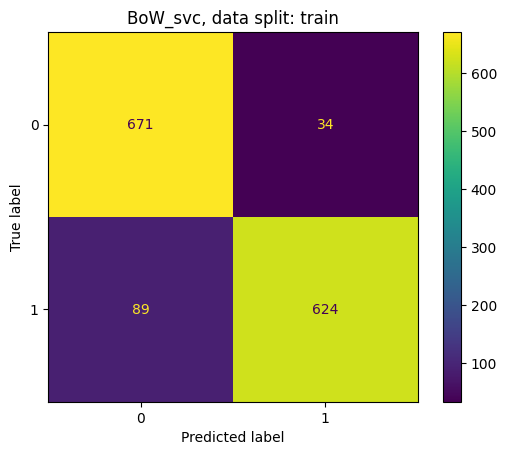

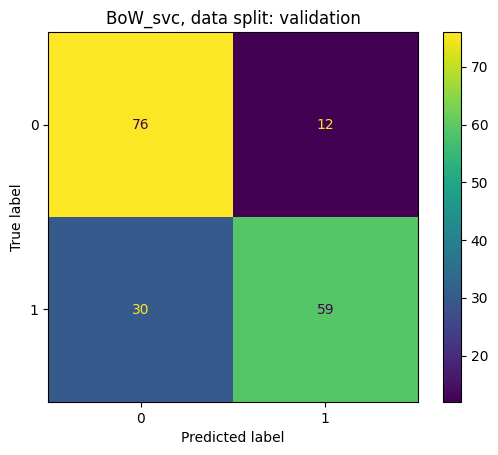

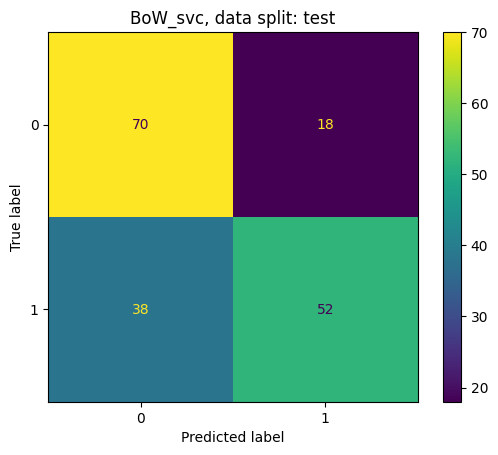

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.7842,0.7770,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.7853,0.7711,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.7135,0.6871,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182
3,BoW_rf,train,0.8032,0.7919,0.887491,608,531,97,182,0.845541,0.744741,0.862411,0.255259,0.137589
4,BoW_rf,validation,0.7458,0.7239,0.841420,73,59,15,30,0.797297,0.662921,0.829545,0.337079,0.170455
5,BoW_rf,test,0.6742,0.6375,0.736111,69,51,19,39,0.728571,0.566667,0.784091,0.433333,0.215909
6,BoW_svc,train,0.9133,0.9103,0.975125,671,624,34,89,0.948328,0.875175,0.951773,0.124825,0.048227
7,BoW_svc,validation,0.7627,0.7375,0.846272,76,59,12,30,0.830986,0.662921,0.863636,0.337079,0.136364
8,BoW_svc,test,0.6854,0.6500,0.756881,70,52,18,38,0.742857,0.577778,0.795455,0.422222,0.204545


In [ ]:
model = clf_svc
model_name = 'BoW_svc'


for x, y, nsplit in zip([features_train, features_val, features_test],
                        [y_train, y_val, y_test],
                        ['train', 'validation', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)

    # Get predicted probabilities for the positive class (class 1)
    y_pred_proba = model.predict_proba(x)[:, 1]  # Probabilities for class 1

    # Compute the ROC AUC score
    roc_auc = roc_auc_score(np.array(y), y_pred_proba)
  
    # create and plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y, preds)
    disp.ax_.set_title(f"{model_name}, data split: {nsplit}")
    #plt.savefig(f'./output/figures/{model_name}_{nsplit}_confusion_matrix.jpeg')
    plt.show()

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'accuracy': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'roc_auc': roc_auc,
         # add confusion matrix values
        'true_negatives': disp.confusion_matrix[0][0],
        'true_positives': disp.confusion_matrix[1][1],
        'false_positives': disp.confusion_matrix[0][1],
        'false_negatives': disp.confusion_matrix[1][0],
        'precision': disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[0][1]),
        'recall':  disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[1][0]),
        'true_negative_rate': disp.confusion_matrix[0][0]/(disp.confusion_matrix[0][0]+disp.confusion_matrix[0][1]),
        'false_negative_rate': disp.confusion_matrix[1][0]/(disp.confusion_matrix[1][1]+disp.confusion_matrix[1][0]),
        'false_positive_rate': disp.confusion_matrix[0][1]/(disp.confusion_matrix[0][1]+disp.confusion_matrix[0][0])
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

In [ ]:
# save model performances
#performance_df.to_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df.csv', index = False)
# reload if stopping mid-way
performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df.csv')

## Plotting BoW most frequent words

In [67]:
# plot distinct words in each label based on frequencies 
# fix variable names
X = features_train.copy()
labels = train_data['passed_bechdel']

# Get the vocabulary mapping (word to column index)
vocabulary = vectorizer.vocabulary_
words = np.array(list(vocabulary.keys()))
word_indices = np.array(list(vocabulary.values()))

# Separate the word frequencies by label
X_label_0 = X[labels == 0].toarray().sum(axis=0)  # Word frequencies for label 0
X_label_1 = X[labels == 1].toarray().sum(axis=0)  # Word frequencies for label 1

# Calculate the difference in frequencies between label 1 and label 0
frequency_diff = X_label_1 - X_label_0

# Apply threshold filtering: Keep words with |frequency_diff| >= 5
threshold = 5
valid_indices = np.where(np.abs(frequency_diff) >= threshold)[0]
filtered_frequency_diff = frequency_diff[valid_indices]
filtered_words = words[word_indices.argsort()][valid_indices]

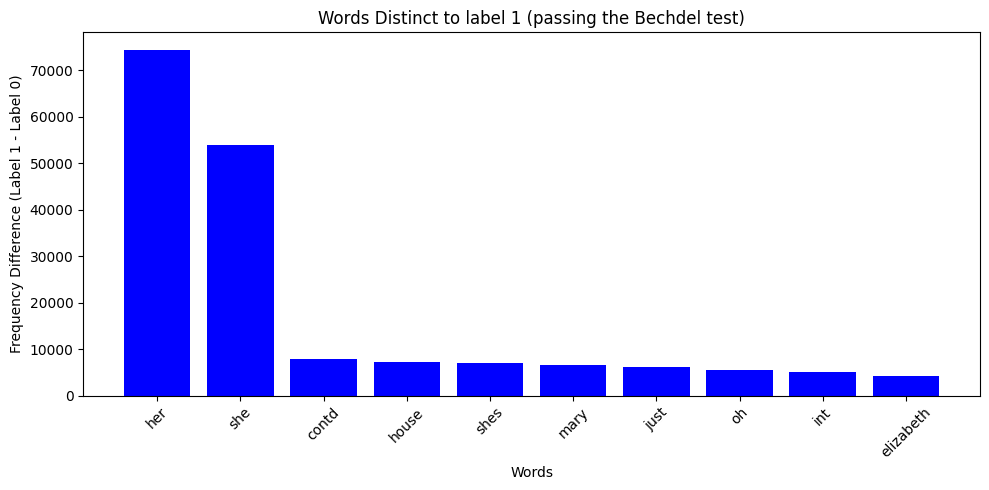

In [ ]:
# Find the top 10 words distinct to label 1
top_indices_distinct_label_1 = np.argsort(filtered_frequency_diff)[-10:][::-1]  # Largest positive differences
distinct_words_label_1 = filtered_words[top_indices_distinct_label_1]
distinct_frequencies_label_1 = filtered_frequency_diff[top_indices_distinct_label_1]

# Plot the distinct words for label 1
plt.figure(figsize=(10, 5))
plt.bar(distinct_words_label_1, distinct_frequencies_label_1, color='blue')
plt.title("Words Distinct to label 1 (passing the Bechdel test)")
plt.xlabel("Words")
plt.ylabel("Frequency Difference (Label 1 - Label 0)")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../figures/BoW_words_label1.jpeg', format='jpeg', dpi=300) 

plt.show()

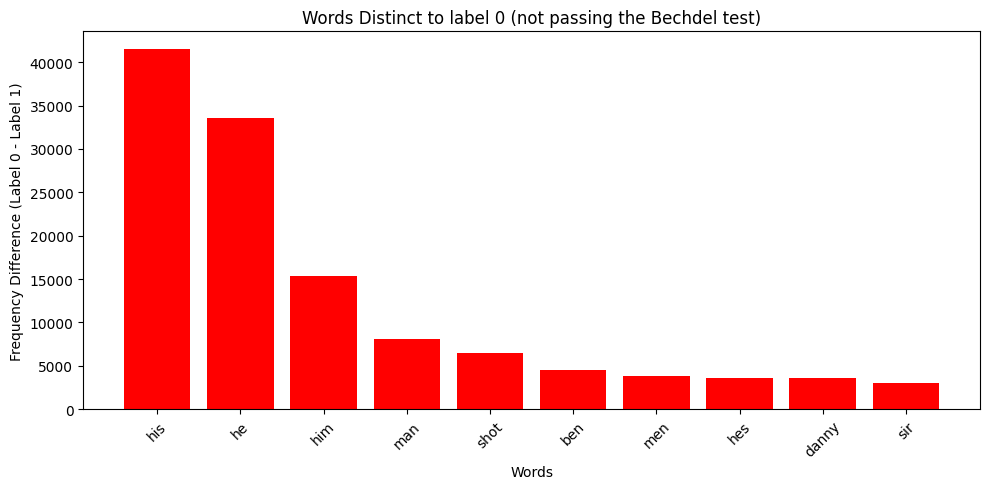

In [ ]:
# Find the top 10 words distinct to label 0
top_indices_distinct_label_0 = np.argsort(filtered_frequency_diff)[:10]  # Largest positive differences
distinct_words_label_0 = filtered_words[top_indices_distinct_label_0]
distinct_frequencies_label_0 = filtered_frequency_diff[top_indices_distinct_label_0]

# Plot the distinct words for label 0
plt.figure(figsize=(10, 5))
plt.bar(distinct_words_label_0, -distinct_frequencies_label_0, color='red')  # Flip sign for better visualization
plt.title("Words Distinct to label 0 (not passing the Bechdel test)")
plt.xlabel("Words")
plt.ylabel("Frequency Difference (Label 0 - Label 1)")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../figures/BoW_words_label0.jpeg', format='jpeg', dpi=300) 

plt.show()


### BoW wordclouds

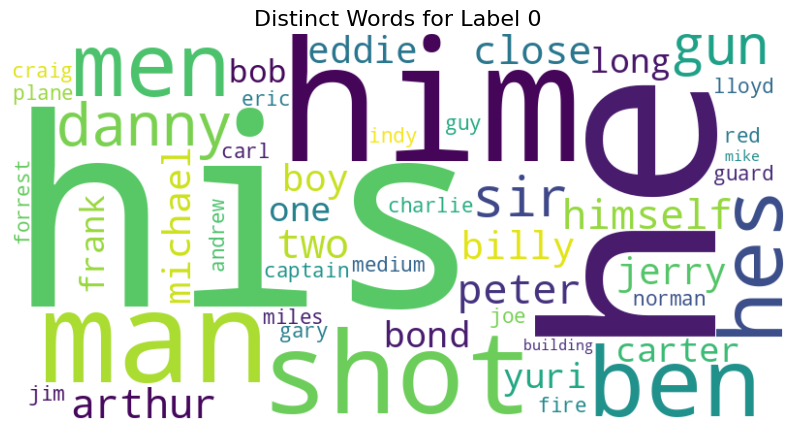

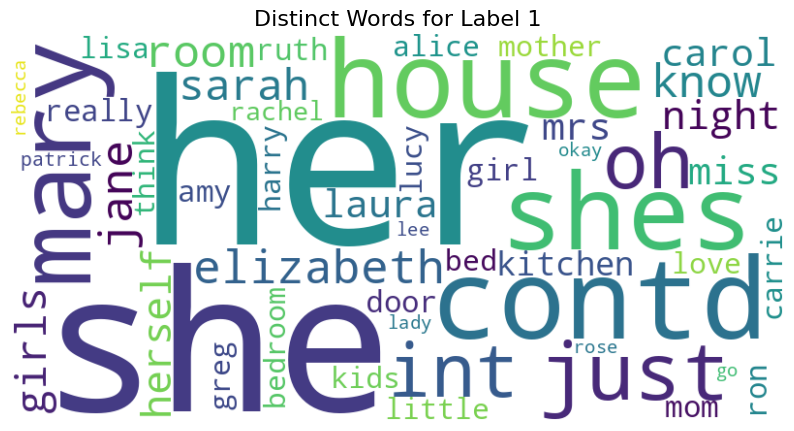

In [71]:
# Step 1: Define and preprocess variables
X = features_train.copy()  # Frequency matrix
labels = train_data['passed_bechdel']  # Binary label (0 or 1)

# Get the vocabulary mapping (word to column index)
vocabulary = vectorizer.vocabulary_ # vectorizer has already been initialized above
words = np.array(list(vocabulary.keys()))
word_indices = np.array(list(vocabulary.values()))

# Separate the word frequencies by label
X_label_0 = X[labels == 0].toarray().sum(axis=0)  # Word frequencies for label 0
X_label_1 = X[labels == 1].toarray().sum(axis=0)  # Word frequencies for label 1

# Calculate the difference in frequencies between label 1 and label 0
frequency_diff = X_label_1 - X_label_0

# Apply threshold filtering: Keep words with |frequency_diff| >= 5
threshold = 5
valid_indices = np.where(np.abs(frequency_diff) >= threshold)[0]
filtered_frequency_diff = frequency_diff[valid_indices]
filtered_words = words[word_indices.argsort()][valid_indices]

# Step 2: Find distinct words for each label
# Top 50 words distinct to label 1
top_indices_distinct_label_1 = np.argsort(filtered_frequency_diff)[-50:][::-1]  # Largest positive differences
distinct_words_label_1 = filtered_words[top_indices_distinct_label_1]
distinct_frequencies_label_1 = filtered_frequency_diff[top_indices_distinct_label_1]

# Top 50 words distinct to label 0
top_indices_distinct_label_0 = np.argsort(filtered_frequency_diff)[:50]  # Largest negative differences
distinct_words_label_0 = filtered_words[top_indices_distinct_label_0]
distinct_frequencies_label_0 = filtered_frequency_diff[top_indices_distinct_label_0]

path = "/work/classes/NLP_exam/figures/"

# Step 3: Create WordClouds for the distinct words
def generate_wordcloud_from_filtered(words, frequencies, title, file_name):

    word_freq = dict(zip(words, np.abs(frequencies)))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plot the WordCloud with a title
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    
    # Save the plot 
    plt.savefig(path + file_name, bbox_inches='tight', dpi=300)
    plt.show()

# WordCloud for distinct words in label 0
generate_wordcloud_from_filtered(
    distinct_words_label_0, 
    distinct_frequencies_label_0, 
    "Distinct Words for Label 0",
    "wordcloud_label0.jpeg")

# WordCloud for distinct words in label 1
generate_wordcloud_from_filtered(
    distinct_words_label_1, 
    distinct_frequencies_label_1, 
    "Distinct Words for Label 1", 
    "wordcloud_label1.jpeg")

## TF-IDF
We'll now the same but using a normalized count-based model called term-frequency inverse document-frequency (tf-idf).

In [72]:
# initializing the new tf-idf vectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words_list)

# fitting the training data
tf_idf_features_train = vectorizer.fit_transform(texts_train)

# transforming the validation and test data
tf_idf_features_val = vectorizer.transform(texts_val)
tf_idf_features_test = vectorizer.transform(texts_test)

# y values are the same as before

In [76]:
# sanity checking
print(tf_idf_features_train.shape)
vectorizer.vocabulary_


(1418, 338922)


{'alice': 24701,
 'linda': 179220,
 'woolverton': 330891,
 'based': 41048,
 'alices': 24711,
 'adventures': 21215,
 'wonderland': 330537,
 'looking': 181783,
 'glass': 129724,
 'lewis': 177758,
 'carroll': 60815,
 '9908': 16306,
 'white': 326972,
 'shooting': 267331,
 'script': 260719,
 '102808': 1088,
 'blue': 48735,
 'revised': 249143,
 'pages': 221393,
 'fade': 111267,
 'ext': 109933,
 'london': 181351,
 '1855': 5003,
 'night': 207062,
 'warm': 322539,
 'light': 178556,
 'shines': 266610,
 'study': 285736,
 'gracious': 132747,
 'kingsley': 170331,
 'home': 147649,
 'man': 186160,
 'silhouetted': 269457,
 'window': 328758,
 'speaks': 277793,
 'ardor': 31937,
 'int': 157999,
 'cont': 74488,
 'charles': 64442,
 'just': 167097,
 'described': 87718,
 'his': 146323,
 'new': 206166,
 'venture': 317794,
 'friends': 122549,
 'including': 155655,
 'lord': 182094,
 'ascot': 33634,
 'finally': 115824,
 'lost': 182270,
 'senses': 263391,
 'colleague': 71228,
 'impossible': 155013,
 'gentlemen': 

Same procedure as with the BoW, testing the vectorizer as a classfier using different statistical models (logistic regression, random forest and SVC). I will try to implement them with the same hyperparameters as above. 

##### Update:
- __Logistic Regression__: The regularization parameter C was changed from 0.001 to 1, because was too constrained in that it ended up only predicting one of the two labels at every prediction.


### TF-IDF Logistic regression

In [ ]:
#initializing logistic regression model again
tf_idf_log_reg = LogisticRegression(
    penalty = 'elasticnet', 
    C = 1.1,  ## CHANGED THIS FROM 0.001 to 1.1, so that it doesn't underfit
   # random_state=42, doesn't make a difference in logreg
    solver = 'saga',
    max_iter = 10000, 
    l1_ratio = 0.5
    ).fit(tf_idf_features_train, y_train) 

In [ ]:
# save / reload model
#pkl.dump(tf_idf_log_reg, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_log_reg.pkl', 'wb')) # save the model
tf_idf_log_reg = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_log_reg.pkl','rb'))

In [92]:
#checking that both labels are predicted
print("Unique predictions in validation set:", np.unique(tf_idf_log_reg.predict(tf_idf_features_val)))

Unique predictions in validation set: [0 1]


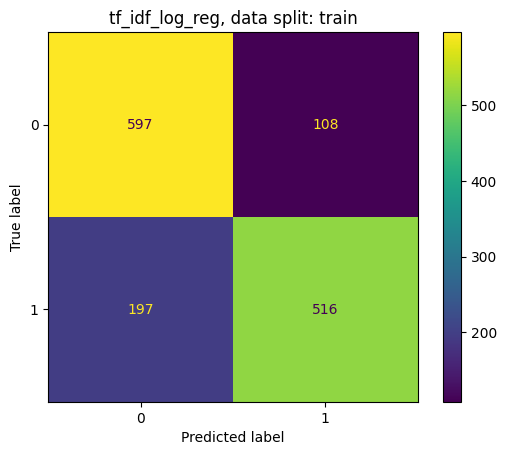

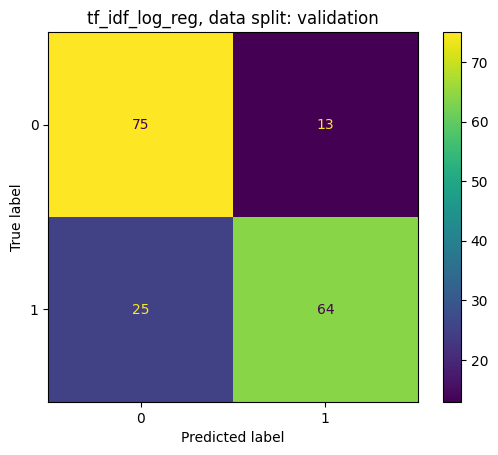

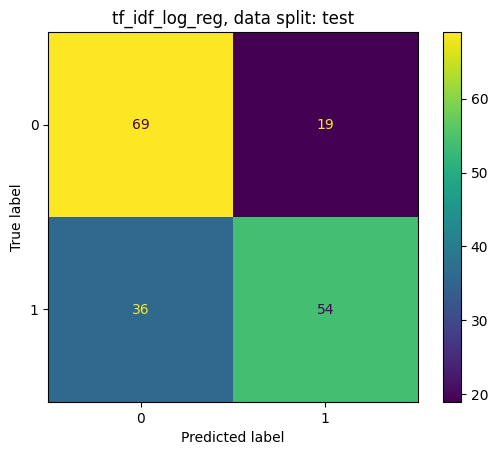

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.7842,0.7770,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.7853,0.7711,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.7135,0.6871,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182
3,BoW_rf,train,0.8032,0.7919,0.887491,608,531,97,182,0.845541,0.744741,0.862411,0.255259,0.137589
4,BoW_rf,validation,0.7458,0.7239,0.841420,73,59,15,30,0.797297,0.662921,0.829545,0.337079,0.170455
5,BoW_rf,test,0.6742,0.6375,0.736111,69,51,19,39,0.728571,0.566667,0.784091,0.433333,0.215909
6,BoW_svc,train,0.9133,0.9103,0.975125,671,624,34,89,0.948328,0.875175,0.951773,0.124825,0.048227
7,BoW_svc,validation,0.7627,0.7375,0.846272,76,59,12,30,0.830986,0.662921,0.863636,0.337079,0.136364
8,BoW_svc,test,0.6854,0.6500,0.756881,70,52,18,38,0.742857,0.577778,0.795455,0.422222,0.204545
9,tf_idf_log_reg,train,0.7849,0.7719,0.856647,597,516,108,197,0.826923,0.723703,0.846809,0.276297,0.153191


In [94]:
# evaluate model on validation dataset and save performance metrics
model = tf_idf_log_reg
model_name = 'tf_idf_log_reg'

for x, y, nsplit in zip([tf_idf_features_train, tf_idf_features_val, tf_idf_features_test],
                        [y_train, y_val, y_test],
                        ['train', 'validation', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)

    # Get predicted probabilities for the positive class (class 1)
    y_pred_proba = model.predict_proba(x)[:, 1]  # Probabilities for class 1

    # Compute the ROC AUC score
    roc_auc = roc_auc_score(np.array(y), y_pred_proba)
  
    # create and plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y, preds)
    disp.ax_.set_title(f"{model_name}, data split: {nsplit}")
    plt.savefig(f'./output/figures/{model_name}_{nsplit}_confusion_matrix.jpeg')
    plt.show()

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'accuracy': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'roc_auc': roc_auc,
      # add confusion matrix values
        'true_negatives': disp.confusion_matrix[0][0],
        'true_positives': disp.confusion_matrix[1][1],
        'false_positives': disp.confusion_matrix[0][1],
        'false_negatives': disp.confusion_matrix[1][0],
        'precision': disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[0][1]),
        'recall':  disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[1][0]),
        'true_negative_rate': disp.confusion_matrix[0][0]/(disp.confusion_matrix[0][0]+disp.confusion_matrix[0][1]),
        'false_negative_rate': disp.confusion_matrix[1][0]/(disp.confusion_matrix[1][1]+disp.confusion_matrix[1][0]),
        'false_positive_rate': disp.confusion_matrix[0][1]/(disp.confusion_matrix[0][1]+disp.confusion_matrix[0][0])
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

### TF-IDF random forest

In [97]:
# tf-idf random forest
# initializing random forest with the hyperparameters from the randomized search 
tf_idf_forest = RandomForestClassifier(
    n_estimators = 100,
    min_samples_split = 10, 
    max_features = 0.9,
    max_depth = 10, 
    ccp_alpha = 0.01,
    random_state=42).fit(tf_idf_features_train, y_train)

In [98]:
#checking that both labels are predicted
print("Unique predictions in validation set:", np.unique(tf_idf_forest.predict(tf_idf_features_val)))

Unique predictions in validation set: [0 1]


In [ ]:
# save / reload model
#pkl.dump(tf_idf_forest, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_forest.pkl', 'wb')) # save the model
tf_idf_forest = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_forest.pkl','rb'))

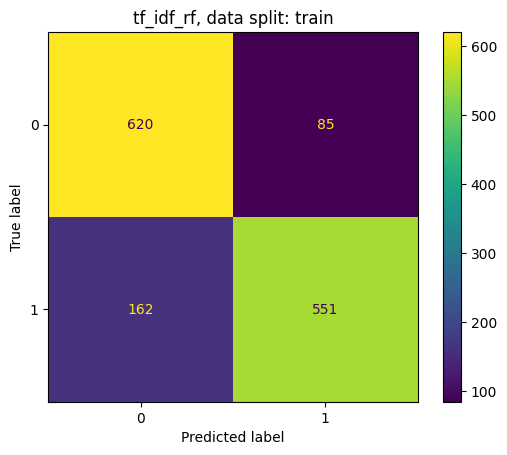

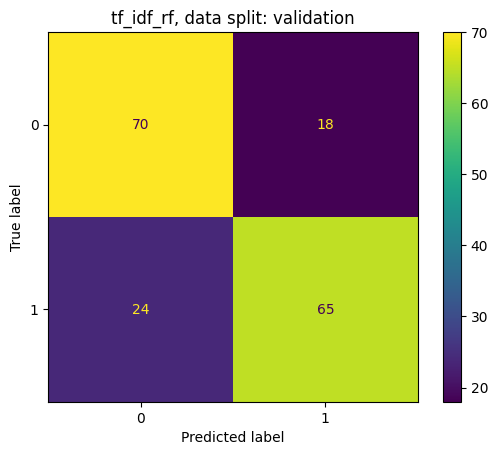

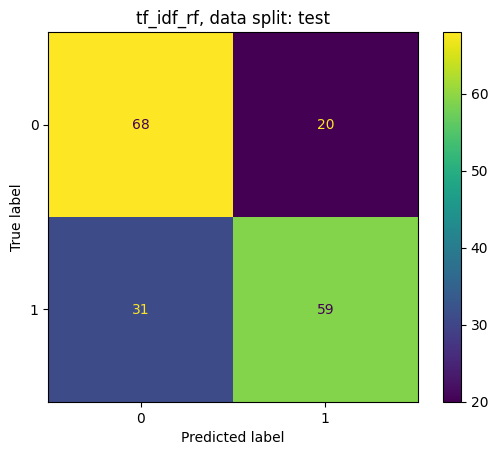

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.7842,0.7770,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.7853,0.7711,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.7135,0.6871,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182
3,BoW_rf,train,0.8032,0.7919,0.887491,608,531,97,182,0.845541,0.744741,0.862411,0.255259,0.137589
4,BoW_rf,validation,0.7458,0.7239,0.841420,73,59,15,30,0.797297,0.662921,0.829545,0.337079,0.170455
5,BoW_rf,test,0.6742,0.6375,0.736111,69,51,19,39,0.728571,0.566667,0.784091,0.433333,0.215909
6,BoW_svc,train,0.9133,0.9103,0.975125,671,624,34,89,0.948328,0.875175,0.951773,0.124825,0.048227
7,BoW_svc,validation,0.7627,0.7375,0.846272,76,59,12,30,0.830986,0.662921,0.863636,0.337079,0.136364
8,BoW_svc,test,0.6854,0.6500,0.756881,70,52,18,38,0.742857,0.577778,0.795455,0.422222,0.204545
9,tf_idf_log_reg,train,0.7849,0.7719,0.856647,597,516,108,197,0.826923,0.723703,0.846809,0.276297,0.153191


In [114]:
model = tf_idf_forest
model_name = 'tf_idf_rf'


for x, y, nsplit in zip([tf_idf_features_train, tf_idf_features_val, tf_idf_features_test],
                        [y_train, y_val, y_test],
                        ['train', 'validation', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)

    # Get predicted probabilities for the positive class (class 1)
    y_pred_proba = model.predict_proba(x)[:, 1]  # Probabilities for class 1

    # Compute the ROC AUC score
    roc_auc = roc_auc_score(np.array(y), y_pred_proba)
  
    # create and plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y, preds)
    disp.ax_.set_title(f"{model_name}, data split: {nsplit}")
    plt.savefig(f'./output/figures/{model_name}_{nsplit}_confusion_matrix.jpeg')
    plt.show()

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'accuracy': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'roc_auc': roc_auc,
         # add confusion matrix values
        'true_negatives': disp.confusion_matrix[0][0],
        'true_positives': disp.confusion_matrix[1][1],
        'false_positives': disp.confusion_matrix[0][1],
        'false_negatives': disp.confusion_matrix[1][0],
        'precision': disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[0][1]),
        'recall':  disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[1][0]),
        'true_negative_rate': disp.confusion_matrix[0][0]/(disp.confusion_matrix[0][0]+disp.confusion_matrix[0][1]),
        'false_negative_rate': disp.confusion_matrix[1][0]/(disp.confusion_matrix[1][1]+disp.confusion_matrix[1][0]),
        'false_positive_rate': disp.confusion_matrix[0][1]/(disp.confusion_matrix[0][1]+disp.confusion_matrix[0][0])
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

In [ ]:
#performance_df.to_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df.csv', index = False)

### TF-IDF SVC
SVC = support vector classifier (statistical model)

In [ ]:
# support vector maching # max_iter=500
tf_idf_svc = SVC(C=0.4, kernel = 'rbf', probability=True, random_state = 42).fit(tf_idf_features_train, y_train)
# changed C from 1 to 0.4 because the model was overfitting to the training data
# 0.2 = only predicts label 1, too regularized
# 0.4 is about the same as 0.3,

In [134]:
# save / reload model
#pkl.dump(tf_idf_svc, file=open(f'/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_svc.pkl', 'wb')) # save the model
tf_idf_svc = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_svc.pkl','rb'))

In [131]:
#checking that both labels are predicted
print("Unique predictions in validation set:", np.unique(tf_idf_svc.predict(tf_idf_features_val)))

Unique predictions in validation set: [0 1]


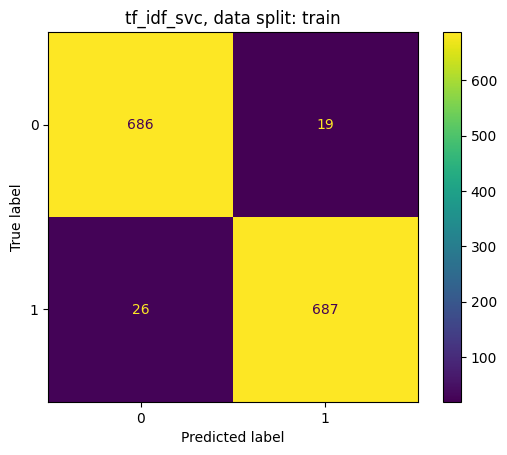

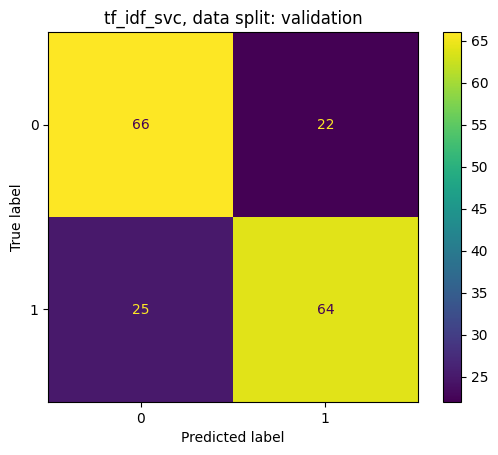

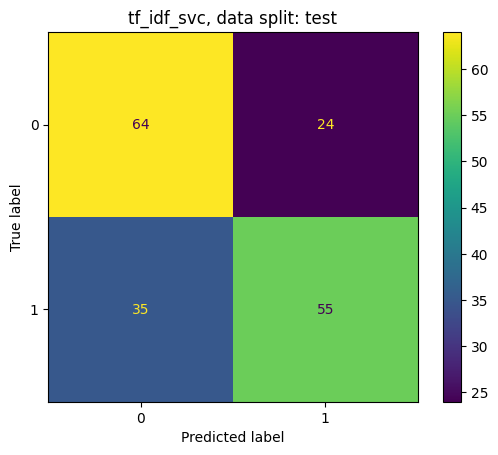

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.7842,0.7770,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.7853,0.7711,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.7135,0.6871,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182
3,BoW_rf,train,0.8032,0.7919,0.887491,608,531,97,182,0.845541,0.744741,0.862411,0.255259,0.137589
4,BoW_rf,validation,0.7458,0.7239,0.841420,73,59,15,30,0.797297,0.662921,0.829545,0.337079,0.170455
5,BoW_rf,test,0.6742,0.6375,0.736111,69,51,19,39,0.728571,0.566667,0.784091,0.433333,0.215909
6,BoW_svc,train,0.9133,0.9103,0.975125,671,624,34,89,0.948328,0.875175,0.951773,0.124825,0.048227
7,BoW_svc,validation,0.7627,0.7375,0.846272,76,59,12,30,0.830986,0.662921,0.863636,0.337079,0.136364
8,BoW_svc,test,0.6854,0.6500,0.756881,70,52,18,38,0.742857,0.577778,0.795455,0.422222,0.204545
9,tf_idf_log_reg,train,0.7849,0.7719,0.856647,597,516,108,197,0.826923,0.723703,0.846809,0.276297,0.153191


In [135]:
model = tf_idf_svc
model_name = 'tf_idf_svc'

for x, y, nsplit in zip([tf_idf_features_train, tf_idf_features_val, tf_idf_features_test],
                        [y_train, y_val, y_test],
                        ['train', 'validation', 'test']):
    mean_accuracy_score = model.score(x, y) 
    preds = model.predict(x)
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds, output_dict = True)

    # Get predicted probabilities for the positive class (class 1)
    y_pred_proba = model.predict_proba(x)[:, 1]  # Probabilities for class 1

    # Compute the ROC AUC score
    roc_auc = roc_auc_score(np.array(y), y_pred_proba)
  
    # create and plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y, preds)
    disp.ax_.set_title(f"{model_name}, data split: {nsplit}")
    plt.savefig(f'./output/figures/{model_name}_{nsplit}_confusion_matrix.jpeg')
    plt.show()

    # Create a dictionary with metrics for the current split
    metrics = {
        'model': model_name,
        'split': nsplit,
        'accuracy': round(mean_accuracy_score, 4),
        'f1_score': round(f1, 4),
        'roc_auc': roc_auc,
         # add confusion matrix values
        'true_negatives': disp.confusion_matrix[0][0],
        'true_positives': disp.confusion_matrix[1][1],
        'false_positives': disp.confusion_matrix[0][1],
        'false_negatives': disp.confusion_matrix[1][0],
        'precision': disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[0][1]),
        'recall':  disp.confusion_matrix[1][1]/(disp.confusion_matrix[1][1]+ disp.confusion_matrix[1][0]),
        'true_negative_rate': disp.confusion_matrix[0][0]/(disp.confusion_matrix[0][0]+disp.confusion_matrix[0][1]),
        'false_negative_rate': disp.confusion_matrix[1][0]/(disp.confusion_matrix[1][1]+disp.confusion_matrix[1][0]),
        'false_positive_rate': disp.confusion_matrix[0][1]/(disp.confusion_matrix[0][1]+disp.confusion_matrix[0][0])
    }
    
    # Convert the dictionary to a DataFrame and concatenate it with the main DataFrame
    performance_df = pd.concat([performance_df, pd.DataFrame([metrics])], ignore_index=True)

# Display the performance metrics
performance_df

In [136]:
# save model performances
performance_df.to_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df.csv', index = False)
# reload if stopping mid-way
#performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performances.csv')

In [ ]:
# code for fixing df if something needs to be rerun 
#performance_df.drop(performance_df.tail(6).index, inplace = True)
#performance_df

## Plotting performances of models

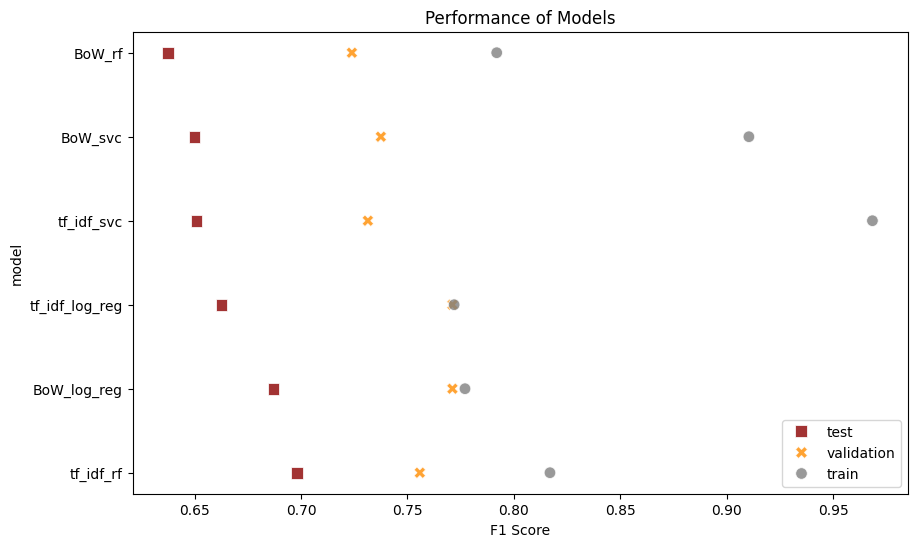

In [ ]:
# Specify the order of the legend and the icons
order = ['test', 'validation', 'train']
markers = {'test': 's', 'validation': 'X', 'train': 'o'}

# Sort the DataFrame by split and f1_score
performance_df['split_order'] = performance_df['split'].map({v: i for i, v in enumerate(order)})  # Map splits to numeric order
performance_df_sorted = performance_df.sort_values(by=['split_order', 'f1_score'], ascending=[True, True])  # Sort by split order and f1_score

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Make wider to show all points
sns.scatterplot(data=performance_df_sorted, 
                y='model', 
                x='f1_score', 
                style='split',
                hue='split', 
                markers=markers,
                palette=['darkred', 'darkorange', 'grey'],
                hue_order=order, 
                style_order=order, 
                s=70,
                alpha=0.8)

# Customize plot
plt.title("Performance of Models")
plt.xlabel("F1 Score")
plt.legend(loc='lower right')  # Adjust legend position

# Remove temporary column used for sorting
performance_df.drop(columns='split_order', inplace=True)
#plt.savefig('../figures/model_performance.jpeg', format='jpeg', dpi=300) 
plt.show()


## Feature importances of best models
so, feature importances of the tf_idf_ random forest and the bag of words logistic regression.

#### Creating virtual env to make SHAP work

This is a bit tricky - if you want to run the same code, you have to follow these steps:

The first time you run the code: 
1. Create a virtual environment by writing the following in the terminal: __python3 -m venv env_shap__


2. Activate the virtual environment by writing this in the terminal (note - please write the correct path): __source path_to_env/bin/activate__ in terminal (on my computer the path is: __/work/classes/NLP_exam/3_model_selection/env_shap/bin/activate__)


3. pip install jupyter and ipykernel in the terminal as well as any other packages we need when running it the first time 


4. Install the __correct__ version of numpy by running: __pip install numpy==2.0__


5. __Pip install shap__ in the terminal 


6. the version which has been installed can be checked by runnning the following in the terminal: __pip list | grep numpy__


7. Use the correct kernel in ucloud - you may have to refresh the browser to get it to appear (when clicking in the kernel icon in the upper right corner)
If the kernel doesn't show up in Python Coder, try running this in the terminal: __python -m ipykernel install --user --name=env_shap__      


8. import packages in the virtual enviroment ucloud kernel


When you have already set up the virtual environment:


1. Run __source /path_to_env/env_shap/bin/activate__ in the terminal (use your own path)


2. Choose the same kernel in Python Coder (may have to refresh for it to appear)


3. Install packages

In [ ]:
!pip install jupyter
!pip install ipykernel
!pip install numpy==2.0
!pip install shap 
#!bash env_setup 

In [ ]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve, average_precision_score, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

import pickle as pkl
import shap
print('np version:', np.__version__)

np version: 2.0.0


### Feature importances of the BoW logistic regression

In [ ]:
############## make BoW features, reload model

# reloading train, test and validation datasets - lowercase!
train_data = pd.read_csv("../2_preprocessing/train_lowercase.csv")
test_data = pd.read_csv("../2_preprocessing/test_lowercase.csv")
val_data = pd.read_csv('../2_preprocessing/validation_lowercase.csv')


# creating frequency matrix using the training data and transforming the validation and the test dataset
# train data 
texts_train = train_data["script"].to_list()
y_train = train_data.passed_bechdel.to_list()

# create frequency matrix of words
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(texts_train) # only for training!

# validation data 
texts_val = val_data["script"].to_list()
y_val = val_data.passed_bechdel.to_list()
features_val = vectorizer.transform(texts_val) # notice - only transform, not fitting

# test data 
texts_test = test_data["script"].to_list()
y_test = test_data.passed_bechdel.to_list()
features_test = vectorizer.transform(texts_test) 

# reload model
clf_log_reg = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/BoW_log_reg_elasticnet_saga.pkl','rb'))

In [ ]:
################# BoW feature importances TRAIN ################
# create explainer for train
feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(clf_log_reg, features_train, feature_names=feature_names)

# compute shap values
shap_values = explainer(features_train)

#plot 
shap.plots.bar(shap_values, max_display=15, show = False)
plt.title("Top 15 features for BoW logistic regression (training data)", fontsize=14)
#plt.savefig('/work/classes/NLP_exam/3_model_selection/output/figures/BoW_log_reg_shap_summary_train_15_features.png', dpi = 700, bbox_inches = 'tight')
plt.show()

Bechdel pass/fail: 1


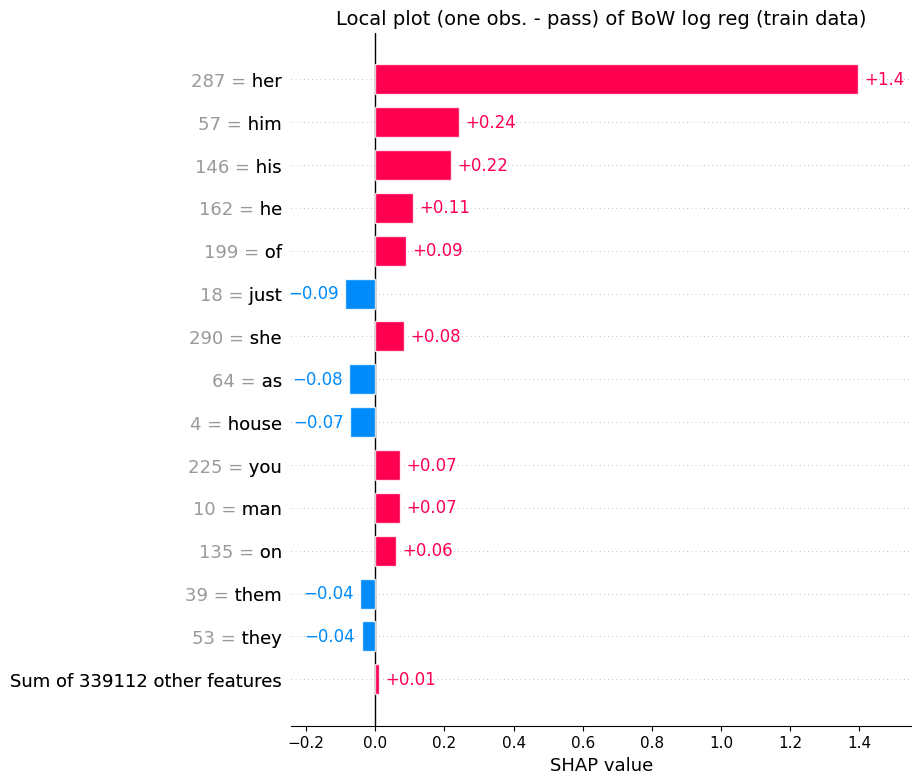

Bechdel pass/fail: 0


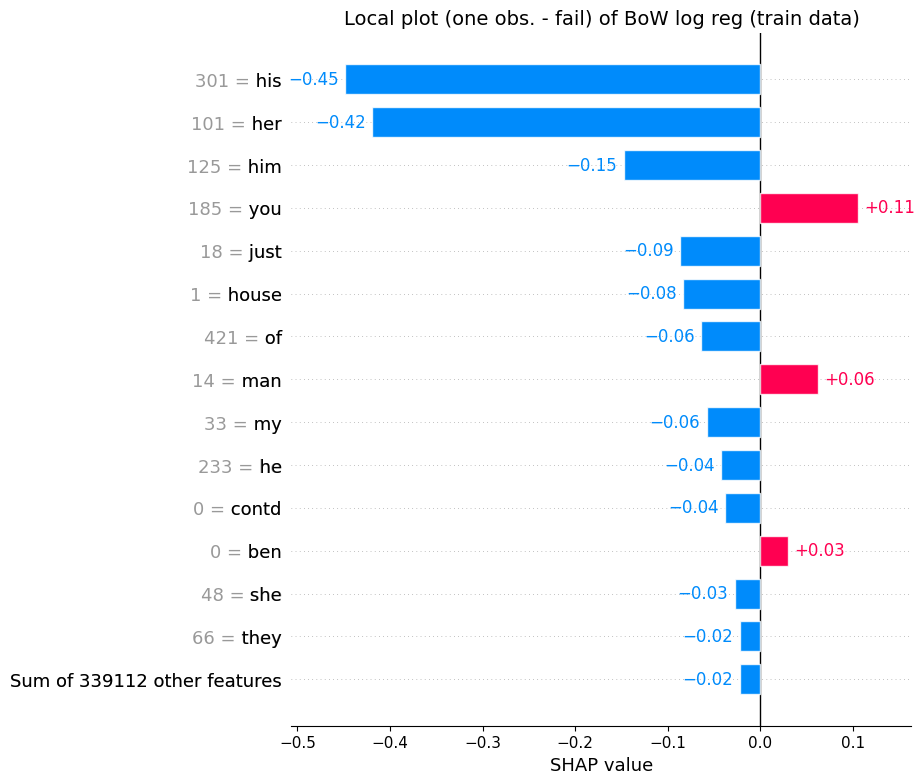

In [ ]:
######## Plotting only one movie #############
print("Bechdel pass/fail:", y_train[0])
# local features imporances for one observation 
shap.plots.bar(shap_values[0], max_display=15, show = False)
plt.title(f"Local plot (one obs. - pass) of BoW log reg (train data)", fontsize=14)
plt.savefig("/work/classes/NLP_exam/3_model_selection/output/figures/BoW_log_reg_shap_summary_local_no_0_train.png",dpi=700, bbox_inches = 'tight') 
plt.show()

print("Bechdel pass/fail:", y_train[1])
# local features imporances for one observation 
shap.plots.bar(shap_values[1], max_display=15, show = False)
plt.title(f"Local plot (one obs. - fail) of BoW log reg (train data)", fontsize=14)
plt.savefig("/work/classes/NLP_exam/3_model_selection/output/figures/BoW_log_reg_shap_summary_local_no_1_train.png",dpi=700, bbox_inches = 'tight') 
plt.show()

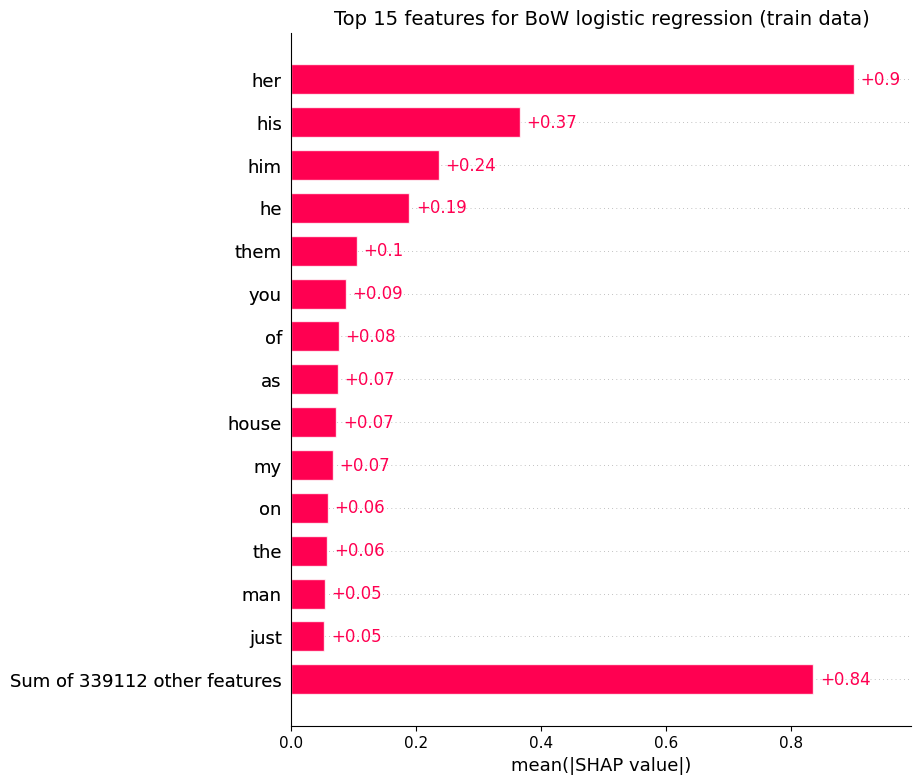

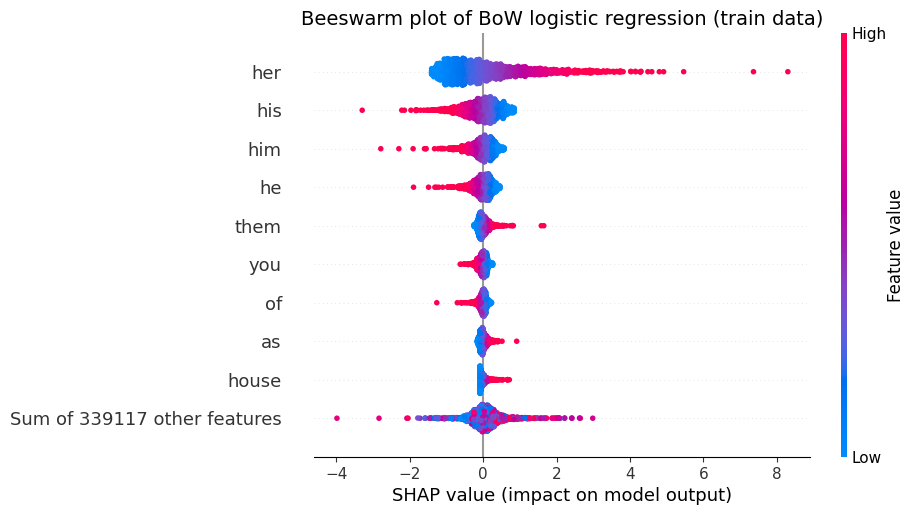

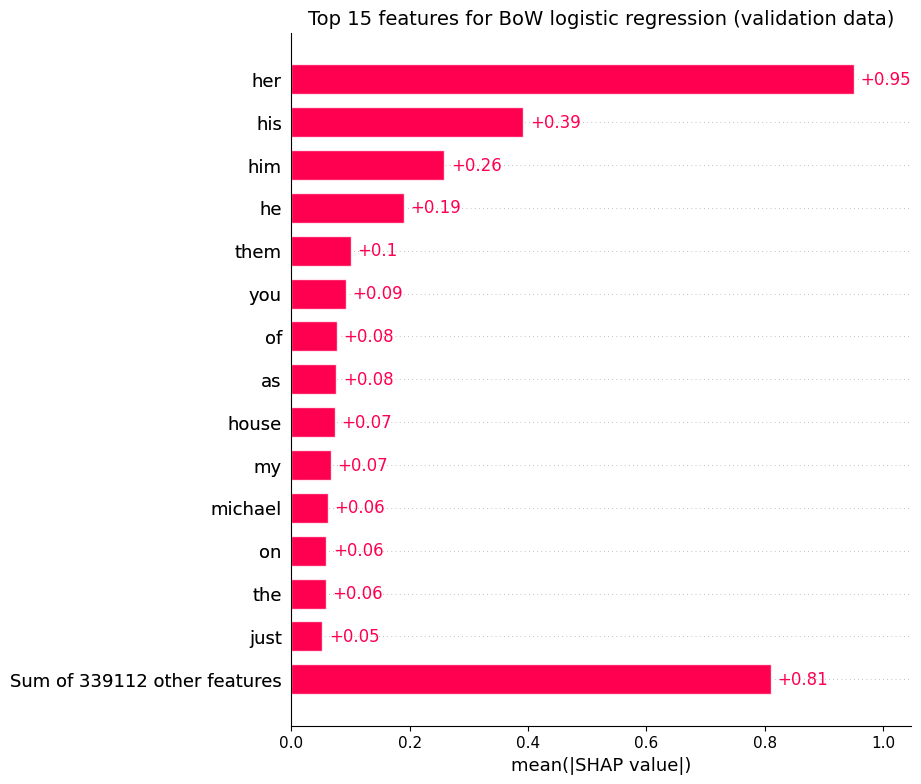

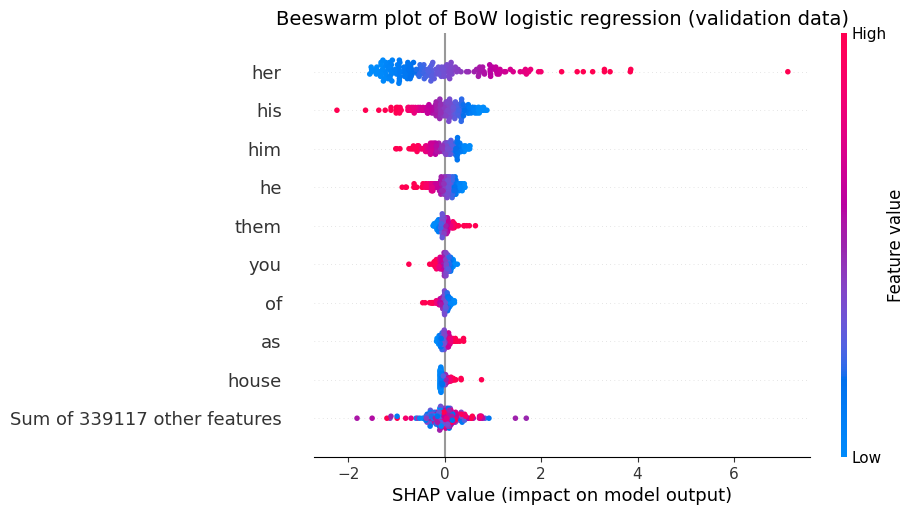

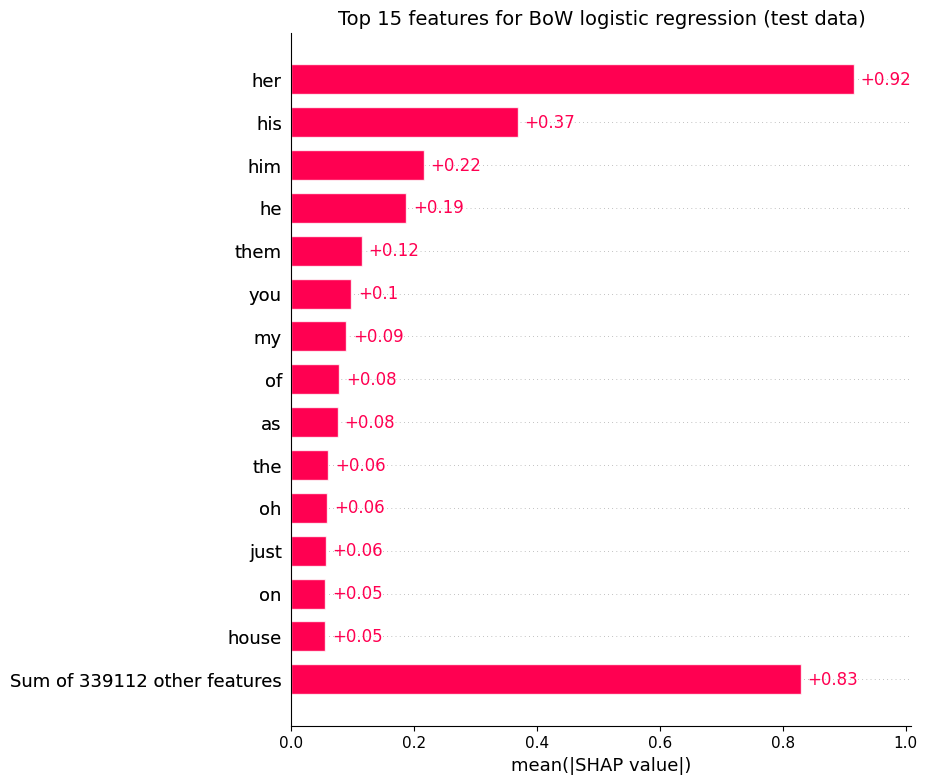

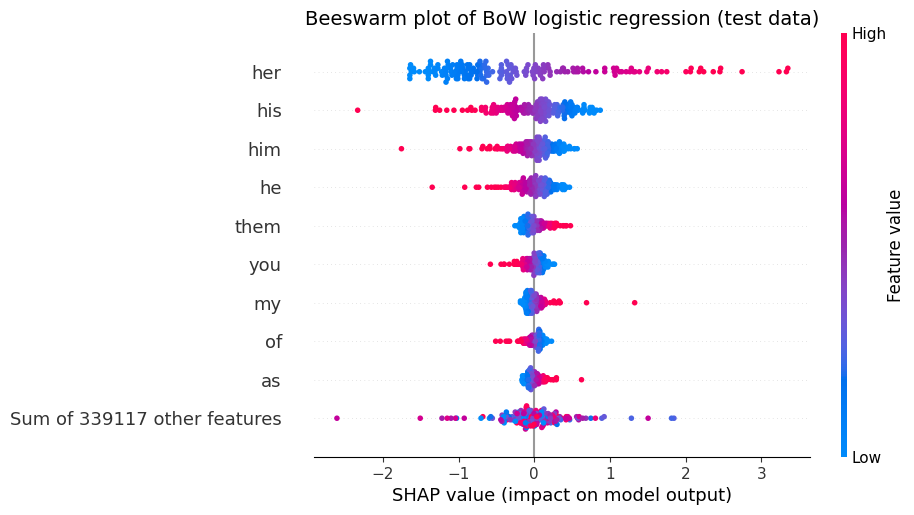

In [ ]:
# make nice code for all three datasets
model_name = 'BoW logistic regression'
feature_names = vectorizer.get_feature_names_out()
num_feat = 15

for x, nsplit in zip([features_train, features_val, features_test],
                        ['train', 'validation', 'test']):
    
    explainer = shap.Explainer(clf_log_reg, x, feature_names=feature_names)
    shap_values = explainer(x)

    #plot summary plot
    shap.plots.bar(shap_values, max_display=num_feat, show = False)
    plt.title(f"Top {num_feat} features for {model_name} ({nsplit} data)", fontsize=14)
    #plt.savefig(f'/work/classes/NLP_exam/3_model_selection/output/figures/BoW_log_reg_shap_summary_{nsplit}_{num_feat}_features.png', dpi = 700, bbox_inches = 'tight')
    plt.show()

    shap.plots.beeswarm(shap_values, show=False)
    plt.title(f"Beeswarm plot of BoW logistic regression ({nsplit} data)", fontsize=14)
    #plt.savefig(f'/work/classes/NLP_exam/3_model_selection/output/figures/BoW_log_reg_shap_beeswarm_{nsplit}.png', dpi = 700, bbox_inches = 'tight')
    plt.show()

### Feature importances of the TF-IDF random forest

In [ ]:
# make tf-idf vectors, reload model 

# initializing the new tf-idf vectorizer and fitting training data
vectorizer = TfidfVectorizer()#max_features = 50)
tf_idf_features_train = vectorizer.fit_transform(texts_train)

# transforming the validation and test data
tf_idf_features_val = vectorizer.transform(texts_val)
tf_idf_features_test = vectorizer.transform(texts_test)

# y values are the same as before

# reload model
tf_idf_forest = pkl.load(open('/work/classes/NLP_exam/3_model_selection/output/models/tf_idf_forest.pkl','rb'))

# get feature names
feature_names = vectorizer.get_feature_names_out()

The random forest classifier works differently than the logistic regression classifier, so the code is a bit different, too. For example, I cannot pass the data and the feature names to the explainer object, I have to add that later. 

In [ ]:
explainer = shap.Explainer(tf_idf_forest)

In [ ]:
train_dense = tf_idf_features_train.toarray()

In [ ]:
train_dense.shape

(1418, 339126)

In [ ]:
shap_values = explainer(train_dense)
shap_values.shape # an extra dimension is added to capture the two classes 

(1418, 339126, 2)

In the extra dimension, "base values" are found. They correspond to the probability distribution of predicting either label 0 or label 1.

In [ ]:
print(len(np.unique(shap_values.base_values)))
print(np.unique(shap_values.base_values))

2
[0.49633992 0.50366008]


In [ ]:
#  SHAP values 
shap_values_all = shap_values[:, :, 0] # 0 or 1, gives the same output in the plot.bar because it is absolute values

# make new explainer to get feature names - cannot be added earlier for reason
explainer_all = shap.Explanation(values=shap_values_all, 
                              feature_names=feature_names)

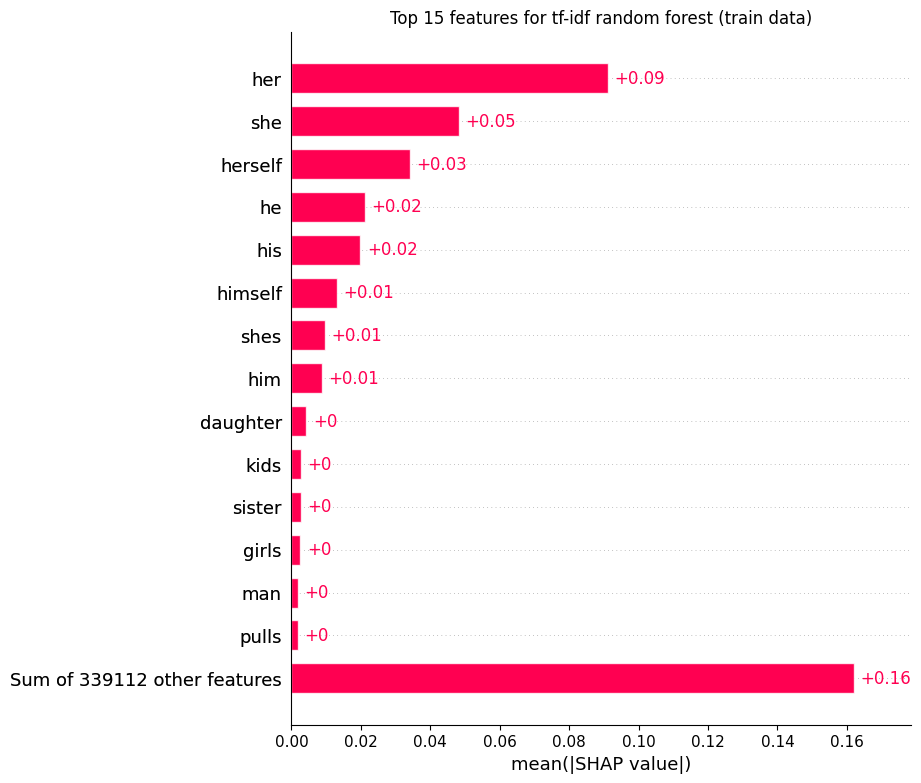

In [ ]:
shap.plots.bar(explainer_all, max_display=15, show=False)
plt.title('Top 15 features for tf-idf random forest (train data)')
plt.show()

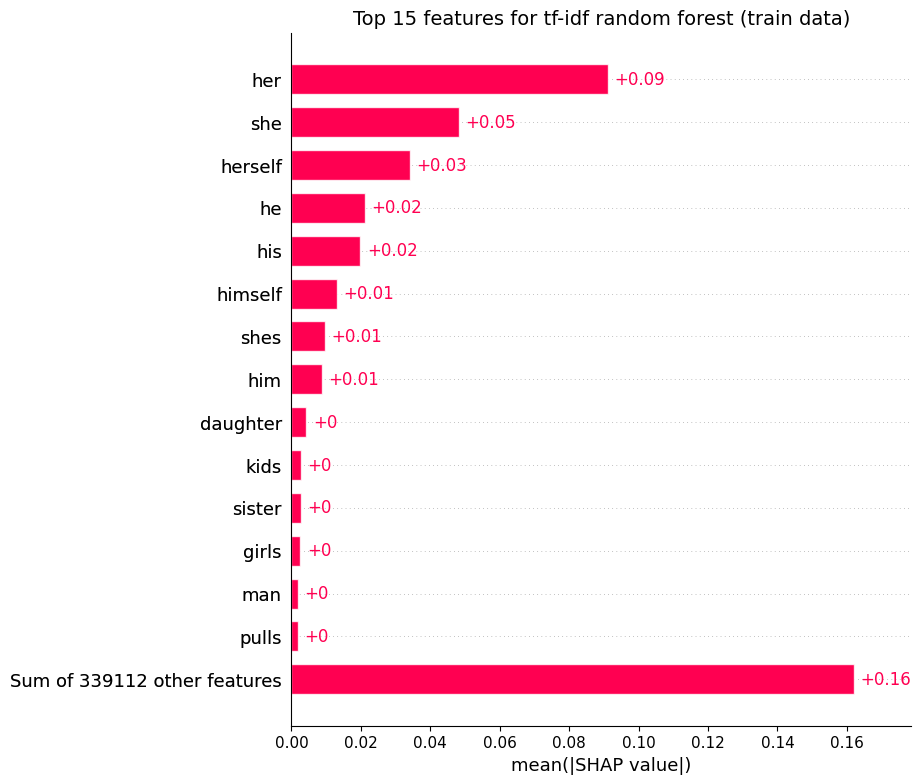

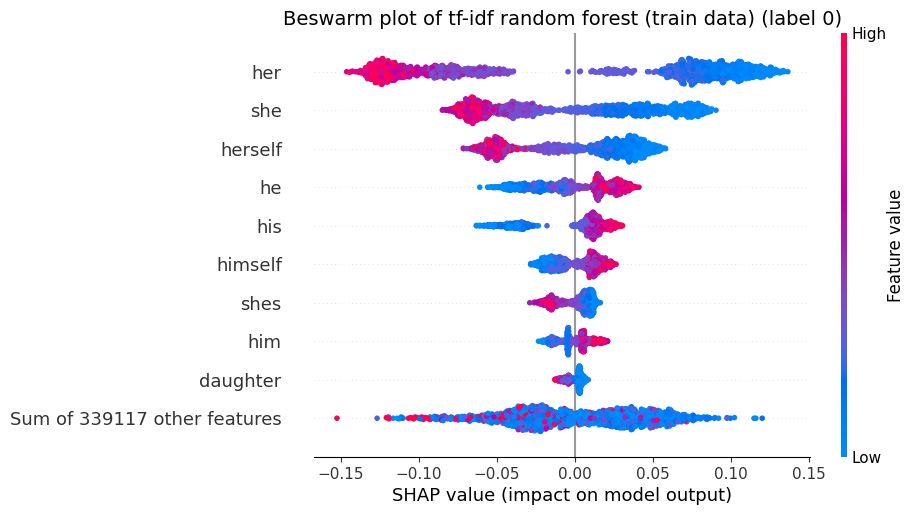

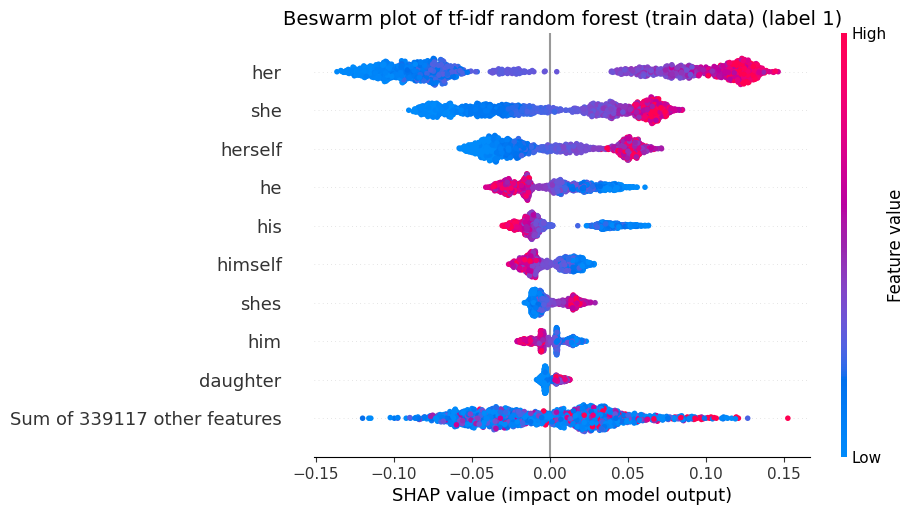

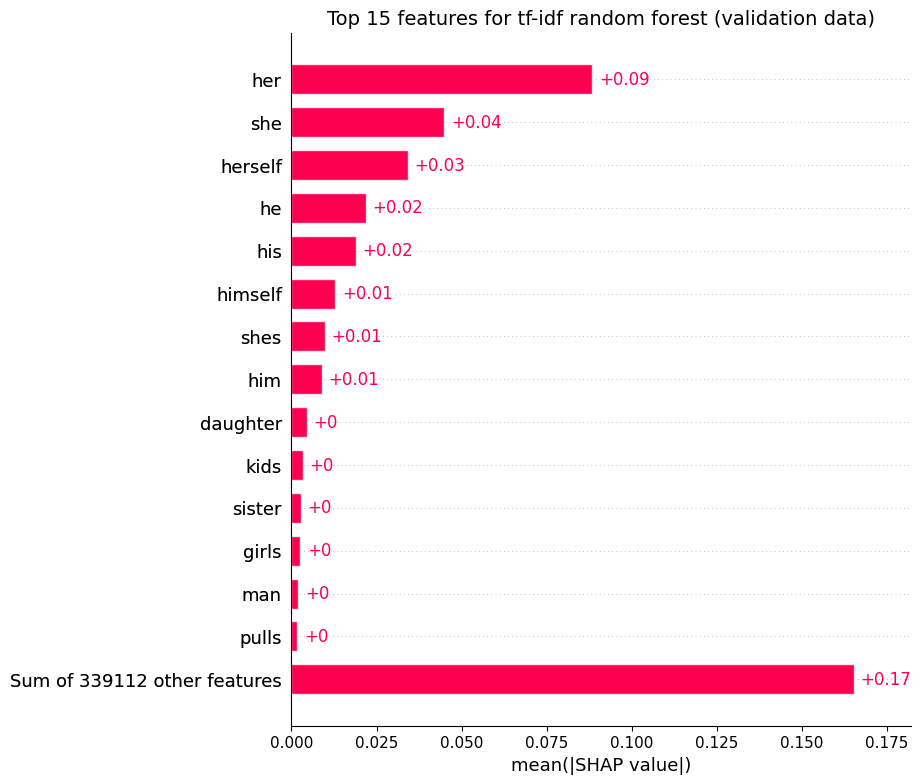

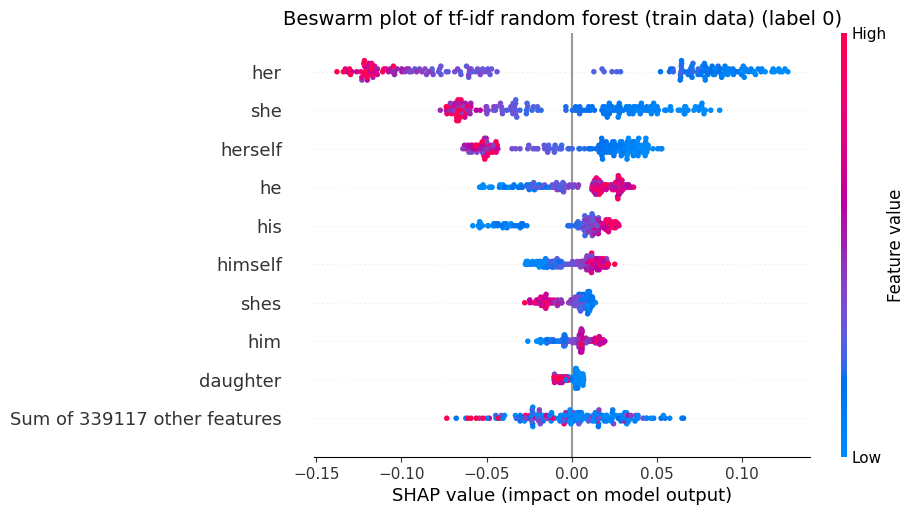

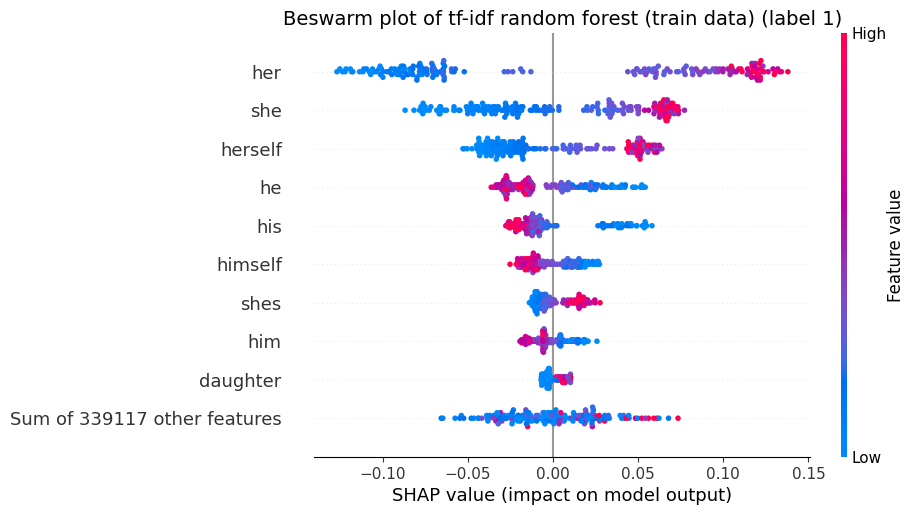

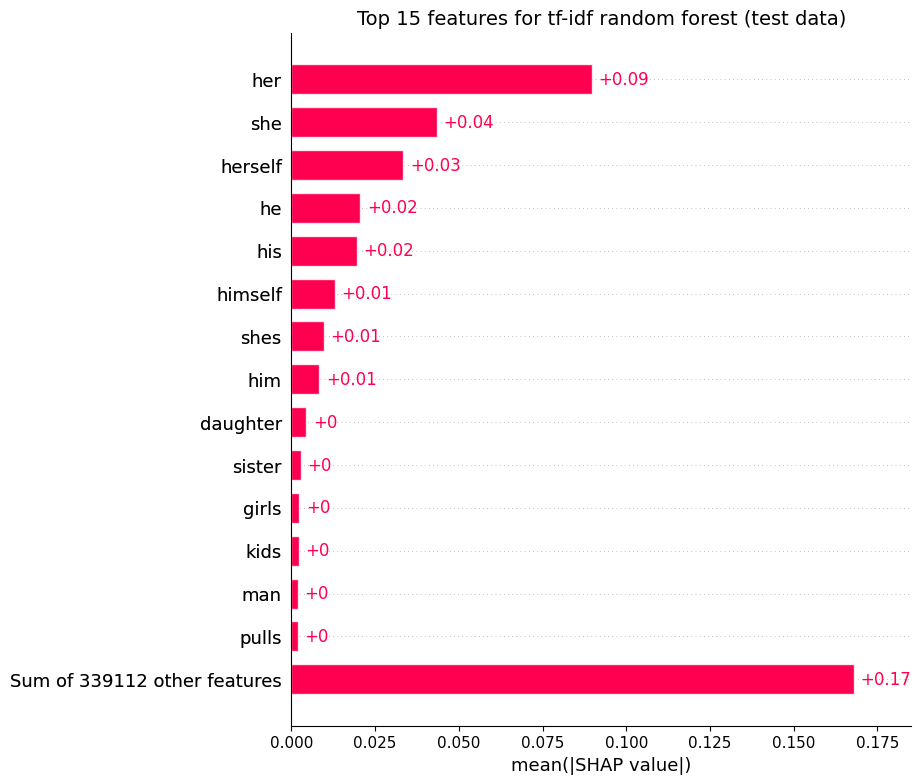

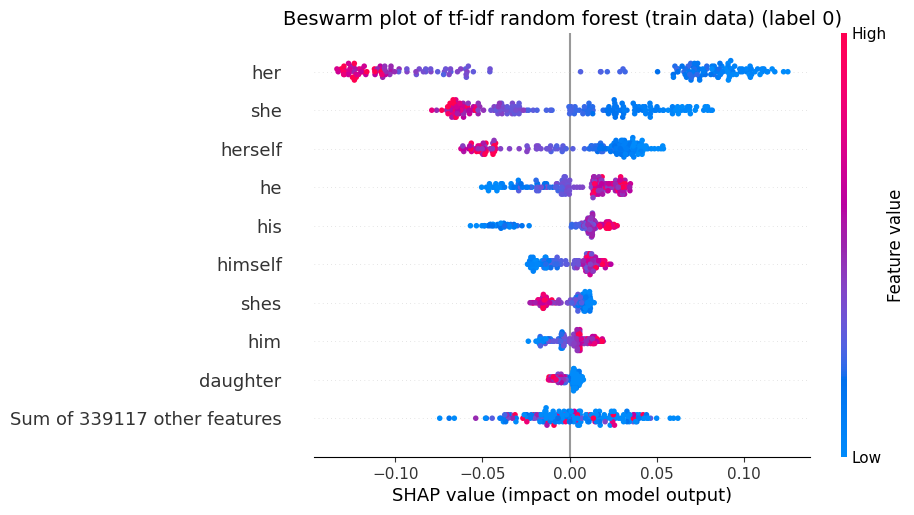

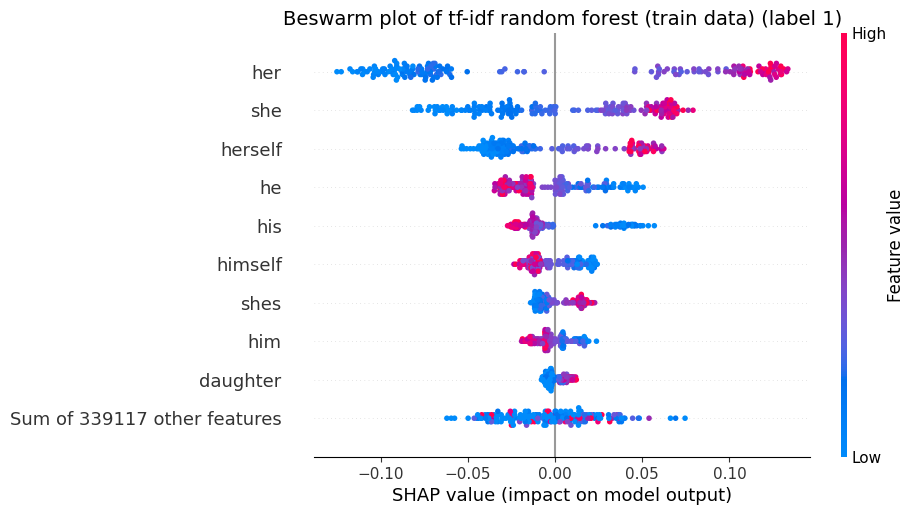

In [ ]:
# make nice code for all three datasets
model_name = 'tf-idf random forest'
model = tf_idf_forest

num_feat = 15

for x, nsplit in zip([tf_idf_features_train, tf_idf_features_val, tf_idf_features_test],
                        ['train', 'validation', 'test']):
    
    # explainer init
    explainer = shap.Explainer(model)

    # create and sort shap values 
    shap_values = explainer(x.toarray())
    shap_values_all = shap_values[:, :, 0] # 0 or 1, gives the same output in the plot.bar because it is absolute values

    # make new explainer to get feature names - cannot be added earlier for some reason
    explainer_all = shap.Explanation(values=shap_values_all, 
                              feature_names=feature_names)  

    #plot summary plot
    shap.plots.bar(explainer_all, max_display=num_feat, show = False)
    plt.title(f"Top {num_feat} features for {model_name} ({nsplit} data)", fontsize=14)
    #plt.savefig(f'/work/classes/NLP_exam/3_model_selection/output/figures/tf_idf_rf_shap_summary_{nsplit}_{num_feat}_features.png', dpi = 700, bbox_inches = 'tight')
    plt.show()

    # beswarm
    shap_values_0 = shap_values[:, :, 0] 
    shap_values_1 = shap_values[:, :, 1] 

    explainer_0 = shap.Explanation(values=shap_values_0, 
                              feature_names=feature_names)

    explainer_1 = shap.Explanation(values=shap_values_1, 
                              feature_names=feature_names)

    shap.plots.beeswarm(explainer_0, show=False)
    plt.title('Beswarm plot of tf-idf random forest (train data) (label 0)', fontsize=14)
    plt.savefig(f'/work/classes/NLP_exam/3_model_selection/output/figures/tf_idf_rf_beeswarm_{nsplit}_label0.png', dpi = 700, bbox_inches = 'tight')
    plt.show()

    shap.plots.beeswarm(explainer_1, show=False)
    plt.title('Beswarm plot of tf-idf random forest (train data) (label 1)', fontsize=14)
    plt.savefig(f'/work/classes/NLP_exam/3_model_selection/output/figures/tf_idf_rf_beeswarm_{nsplit}_label1.png', dpi = 700, bbox_inches = 'tight')
    plt.show()

bar plots are the same. beeswarm differs a little

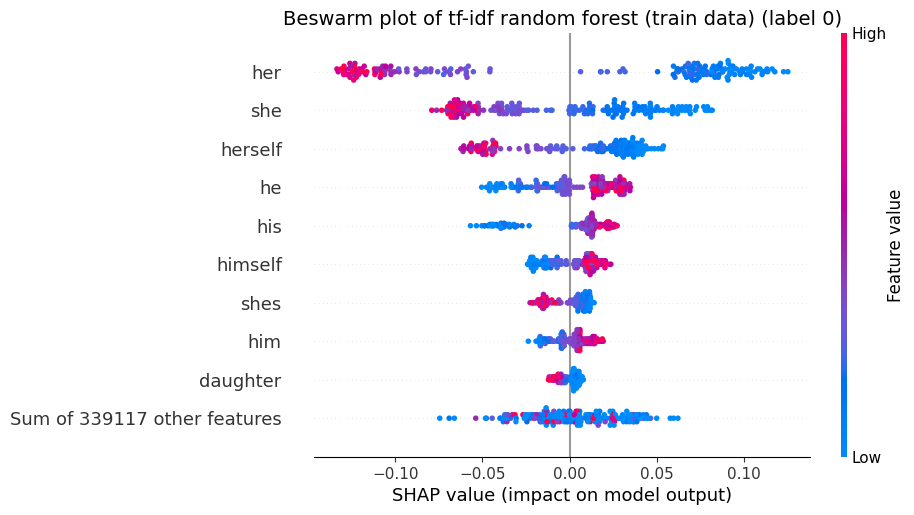

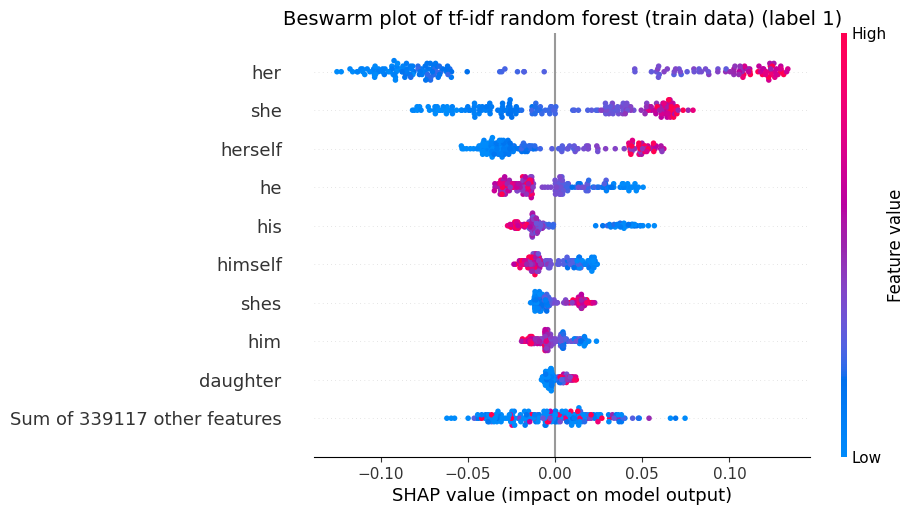

In [ ]:
# beswarm for train only
shap_values_0 = shap_values[:, :, 0] 
shap_values_1 = shap_values[:, :, 1] 

# make new explainer to get feature names - cannot be added earlier for reason
explainer_0 = shap.Explanation(values=shap_values_0, 
                              feature_names=feature_names)

explainer_1 = shap.Explanation(values=shap_values_1, 
                              feature_names=feature_names)

shap.plots.beeswarm(explainer_0, show=False)
plt.title('Beswarm plot of tf-idf random forest (train data) (label 0)', fontsize=14)
plt.savefig(f'/work/classes/NLP_exam/3_model_selection/output/figures/tf_idf_rf_beeswarm_train_label0.png', dpi = 700, bbox_inches = 'tight')
plt.show()

shap.plots.beeswarm(explainer_1, show=False)
plt.title('Beswarm plot of tf-idf random forest (train data) (label 1)', fontsize=14)
plt.savefig(f'/work/classes/NLP_exam/3_model_selection/output/figures/tf_idf_rf_beeswarm_train_label1.png', dpi = 700, bbox_inches = 'tight')
plt.show()

In [ ]:
# # Average the SHAP values across samples for Class 0
# shap_values_class_0_avg = shap_values[:, :, 0].mean(axis=0)

# # Average the SHAP values across samples for Class 1
# shap_values_class_1_avg = shap_values[:, :, 1].mean(axis=0)

# # make new explainer to get feature names - cannot be added earlier for reason
# explainer_0_avg = shap.Explanation(values=shap_values_class_0_avg, 
#                               feature_names=feature_names)

# explainer_1_avg = shap.Explanation(values=shap_values_class_1_avg, 
#                               feature_names=feature_names)


# shap.plots.bar(explainer_0_avg, max_display=15, show=False)
# plt.title('Top 15 Important Features for label 0')
# plt.show()

# shap.plots.bar(explainer_1_avg, max_display=15, show=False)
# plt.title('Top 15 Important Features for label 1')
# plt.show()